In [1]:
import h5py
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
from pathlib import Path
import pyfftw

import bacco

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import plotter
import plot_utils
import utils
import compute_statistics as cs
import data_loader
import generate_params as genp

%load_ext autoreload
%autoreload 2

2026-01-21 18:05:44.369745: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-21 18:05:44.628249: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-21 18:05:44.628287: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-21 18:05:44.652745: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-21 18:05:44.730889: I tensorflow/core/platform/cpu_feature_guar

# Inference: kmax=0.2 for bispec (20x bias per cosmo)

## load training: Anmult p2

In [2]:
data_mode = 'muchisimocks'
tag_params = '_p5_n10000'
tag_biasparams = '_biaszen_p4_n200000'
tag_noise = '_noise_unit_p5_n10000'
tag_Anoise = '_Anmult_p2_n200000'

n_train = 10000
#statistics_arr = [['pk']]
#statistics_arr = [['pk'], ['bispec']]
statistics_arr = [['pk'], ['bispec'], ['pk', 'bispec']]
tag_stats_arr = [f'_{"_".join(statistics)}' for statistics in statistics_arr]
tag_mask_arr = ['', '_kmaxbispec0.2', '_kmaxbispec0.2']

# muchisimocks_pk_p5_n10000_biaszen_p4_n10000_ntrain10000
tags_inf = [
             f'_{data_mode}{tag_stats_arr[i]}{tag_mask_arr[i]}{tag_params}{tag_biasparams}{tag_noise}{tag_Anoise}_ntrain{n_train}' for i in range(len(tag_stats_arr))
            ]
inf_methods = ['sbi']*len(tags_inf)
labels = [utils.get_stat_label(stat) for stat in statistics_arr]
color_pk = '#54afd6'
color_bispec = "#e14e4e"
color_pkbispec = '#b0198f'
colors = [color_pk, color_bispec, color_pkbispec]

In [3]:
# load training set parameters 
params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, Anoise_df, Anoise_dict_fixed, random_ints, random_ints_bias = data_loader.load_params(tag_params, tag_biasparams, tag_Anoise=tag_Anoise)

# for muchisimocks, we will probably want to vary the same params as the training data
cosmo_param_names_vary, bias_param_names_vary, noise_param_names_vary = [], [], []
if params_df is not None:
    cosmo_param_names_vary = params_df.columns.tolist()
# TODO should this be test or train?
if biasparams_df is not None:
    bias_param_names_vary = biasparams_df.columns.tolist()
if Anoise_df is not None:
    noise_param_names_vary = Anoise_df.columns.tolist()
param_names_vary = cosmo_param_names_vary + bias_param_names_vary + noise_param_names_vary
param_labels = [utils.param_label_dict[param_name] for param_name in param_names_vary]
print(param_names_vary)

['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1']


### Inference results: cosmic variance / fixed cosmo (quijote)

In [4]:
# load fixed-cosmo test set
tag_params_test_fixed = '_quijote_p0_n1000'
tag_biasparams_test_fixed = '_b1000_p0_n1'
tag_noise_fixed = '_noise_unit_quijote_p0_n1000'
tag_Anoise_fixed = '_Anmult_p0_n1'
theta_test_fixed = data_loader.load_theta_test(tag_params_test_fixed, tag_biasparams_test_fixed, 
                                               tag_Anoise_test=tag_Anoise_fixed,
                                cosmo_param_names_vary=cosmo_param_names_vary, bias_param_names_vary=bias_param_names_vary,
                                noise_param_names_vary=noise_param_names_vary)
print(theta_test_fixed)
print(len(theta_test_fixed))

# get bounds
_, dict_bounds_cosmo, _ = genp.define_LH_cosmo(tag_params_test_fixed)
_, dict_bounds_bias, _ = genp.define_LH_bias(tag_biasparams_test_fixed)
_, dict_bounds_Anoise, _ = genp.define_LH_Anoise(tag_Anoise_fixed)
extents = {**dict_bounds_cosmo, **dict_bounds_bias, **dict_bounds_Anoise}

tag_Anoise_test _Anmult_p0_n1
['An_homog', 'An_b1']
{'An_homog': 1.0, 'An_b1': 0.0, 'An_b2': 0.0, 'An_bs2': 0.0, 'An_bl': 0.0}
here
11
[0.3175 0.834  0.6711 0.049  0.9624 1.     0.     0.     0.     1.
 0.    ]
11


['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1']
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p2_n200000_ntrain10000/samples_test_muchisimocks_pk_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_bispec_kmaxbispec0.2_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p2_n200000_ntrain10000/samples_test_muchisimocks_bispec_kmaxbispec0.2_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_kmaxbispec0.2_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p2_n200000_ntrain10000/samples_test_muchisimocks_pk_bispec_kmaxbispec0.2_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy


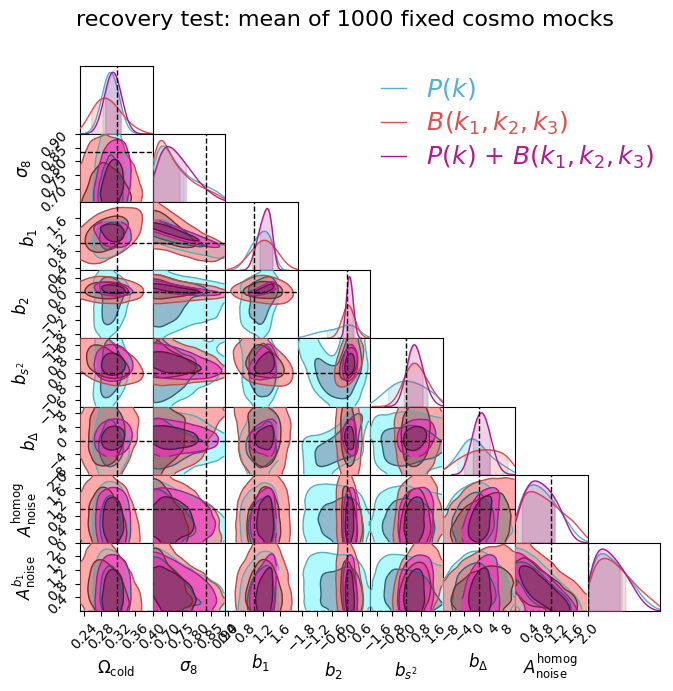

In [5]:
print(param_names_vary)
idx_obs = 0
title = f'recovery test: mean of 1000 fixed cosmo mocks'
tags_stats = [f'_{"_".join(statistics)}' for statistics in statistics_arr]
tags_test = ['_'+data_mode + tag_stats_arr[i] + tag_mask_arr[i] + tag_params_test_fixed + tag_biasparams_test_fixed + tag_noise_fixed + tag_Anoise_fixed + '_mean' for i in range(len(tag_stats_arr))]

#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
# doing utils.biasparam_names_ordered here instead of bias_param_names_vary in case some param sets don't vary all the bias params but we want to show them on the same plot
#param_names_contour = cosmo_param_names_vary + noise_param_names_vary
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered + noise_param_names_vary
theta_test_show = theta_test_fixed[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]

plotter.plot_contours_inf(param_names_contour, idx_obs, theta_test_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents)

### Inference results: shame

In [6]:
# load fixed-cosmo test set
data_mode_test = 'shame'
tag_mock = '_nbar0.00022'
theta_test = data_loader.load_theta_ood(data_mode_test, tag_mock, 
                                cosmo_param_names_vary=cosmo_param_names_vary, bias_param_names_vary=bias_param_names_vary, noise_param_names_vary=noise_param_names_vary)
print(theta_test)

# get bounds
_, dict_bounds_cosmo, _ = genp.define_LH_cosmo(tag_params)
_, dict_bounds_bias, _ = genp.define_LH_bias(tag_biasparams)
_, dict_bounds_Anoise, _ = genp.define_LH_Anoise(tag_Anoise)
extents = {**dict_bounds_cosmo, **dict_bounds_bias, **dict_bounds_Anoise}

[ 0.3089      0.81590003  0.6774      0.0486      0.9667      0.47410742
  0.03175373 -0.16940883 -0.82443643         nan         nan]


['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1']
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p2_n200000_ntrain10000/samples_test_shame_pk_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_bispec_kmaxbispec0.2_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p2_n200000_ntrain10000/samples_test_shame_bispec_kmaxbispec0.2_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_kmaxbispec0.2_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p2_n200000_ntrain10000/samples_test_shame_pk_bispec_kmaxbispec0.2_nbar0.00022_pred.npy


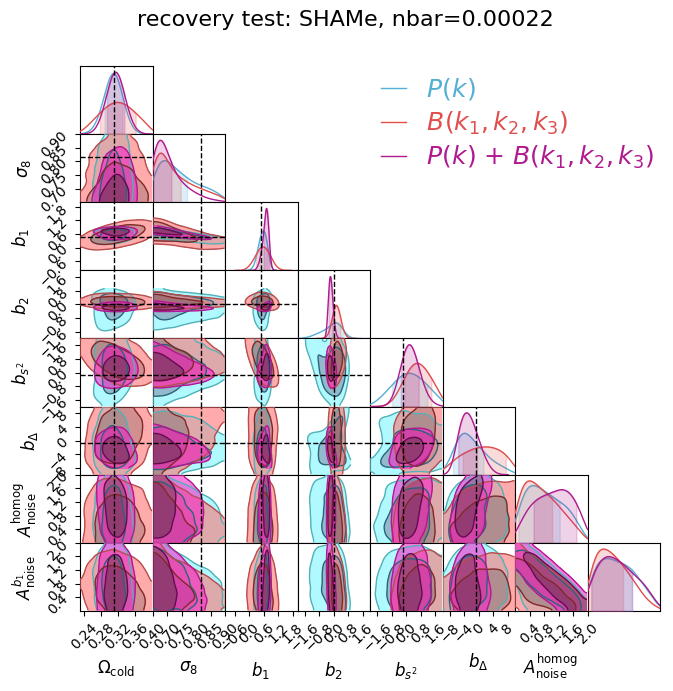

In [7]:
print(param_names_vary)
idx_obs = 0
title = f'recovery test: SHAMe, nbar={tag_mock.split("nbar")[-1]}'
tags_test = ['_'+data_mode_test + tag_stats_arr[i] + tag_mask_arr[i] + tag_mock for i in range(len(tag_stats_arr))]

#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
# doing utils.biasparam_names_ordered here instead of bias_param_names_vary in case some param sets don't vary all the bias params but we want to show them on the same plot
#param_names_contour = cosmo_param_names_vary + noise_param_names_vary
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered + noise_param_names_vary
theta_test_show = theta_test[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]

plotter.plot_contours_inf(param_names_contour, idx_obs, theta_test_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents)

## load training: Anmult p5

In [8]:
data_mode = 'muchisimocks'
tag_params = '_p5_n10000'
tag_biasparams = '_biaszen_p4_n200000'
tag_noise = '_noise_unit_p5_n10000'
tag_Anoise = '_Anmult_p5_n200000'

n_train = 10000
#statistics_arr = [['pk']]
statistics_arr = [['pk'], ['bispec'], ['pk', 'bispec']]
tag_stats_arr = [f'_{"_".join(statistics)}' for statistics in statistics_arr]
tag_mask_arr = ['', '_kmaxbispec0.2', '_kmaxbispec0.2']

# muchisimocks_pk_p5_n10000_biaszen_p4_n10000_ntrain10000
tags_inf = [
             f'_{data_mode}{tag_stats_arr[i]}{tag_mask_arr[i]}{tag_params}{tag_biasparams}{tag_noise}{tag_Anoise}_ntrain{n_train}' for i in range(len(tag_stats_arr))
            ]
inf_methods = ['sbi']*len(tags_inf)
labels = [utils.get_stat_label(stat) for stat in statistics_arr]
color_pk = '#54afd6'
color_bispec = "#e14e4e"
color_pkbispec = '#b0198f'
colors = [color_pk, color_bispec, color_pkbispec]

In [9]:
# load training set parameters 
params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, Anoise_df, Anoise_dict_fixed, random_ints, random_ints_bias = data_loader.load_params(tag_params, tag_biasparams, tag_Anoise=tag_Anoise)

# for muchisimocks, we will probably want to vary the same params as the training data
cosmo_param_names_vary, bias_param_names_vary, noise_param_names_vary = [], [], []
if params_df is not None:
    cosmo_param_names_vary = params_df.columns.tolist()
# TODO should this be test or train?
if biasparams_df is not None:
    bias_param_names_vary = biasparams_df.columns.tolist()
if Anoise_df is not None:
    noise_param_names_vary = Anoise_df.columns.tolist()
param_names_vary = cosmo_param_names_vary + bias_param_names_vary + noise_param_names_vary
param_labels = [utils.param_label_dict[param_name] for param_name in param_names_vary]
print(param_names_vary)

['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1', 'An_b2', 'An_bs2', 'An_bl']


### Inference results: cosmic variance / fixed cosmo (quijote)

In [10]:
# load fixed-cosmo test set
tag_params_test_fixed = '_quijote_p0_n1000'
tag_biasparams_test_fixed = '_b1000_p0_n1'
tag_noise_fixed = '_noise_unit_quijote_p0_n1000'
tag_Anoise_fixed = '_Anmult_p0_n1'
theta_test_fixed = data_loader.load_theta_test(tag_params_test_fixed, tag_biasparams_test_fixed, 
                                               tag_Anoise_test=tag_Anoise_fixed,
                                cosmo_param_names_vary=cosmo_param_names_vary, bias_param_names_vary=bias_param_names_vary,
                                noise_param_names_vary=noise_param_names_vary)
print(theta_test_fixed)
print(len(theta_test_fixed))

# get bounds
_, dict_bounds_cosmo, _ = genp.define_LH_cosmo(tag_params_test_fixed)
_, dict_bounds_bias, _ = genp.define_LH_bias(tag_biasparams_test_fixed)
_, dict_bounds_Anoise, _ = genp.define_LH_Anoise(tag_Anoise_fixed)
extents = {**dict_bounds_cosmo, **dict_bounds_bias, **dict_bounds_Anoise}

tag_Anoise_test _Anmult_p0_n1
['An_homog', 'An_b1', 'An_b2', 'An_bs2', 'An_bl']
{'An_homog': 1.0, 'An_b1': 0.0, 'An_b2': 0.0, 'An_bs2': 0.0, 'An_bl': 0.0}
here
14
[0.3175 0.834  0.6711 0.049  0.9624 1.     0.     0.     0.     1.
 0.     0.     0.     0.    ]
14


['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1', 'An_b2', 'An_bs2', 'An_bl']
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_muchisimocks_pk_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_bispec_kmaxbispec0.2_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_muchisimocks_bispec_kmaxbispec0.2_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_kmaxbispec0.2_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_muchisimocks_pk_bispec_kmaxbispec0.2_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy


Parameter b2 in chain $P(k)$ is not constrained


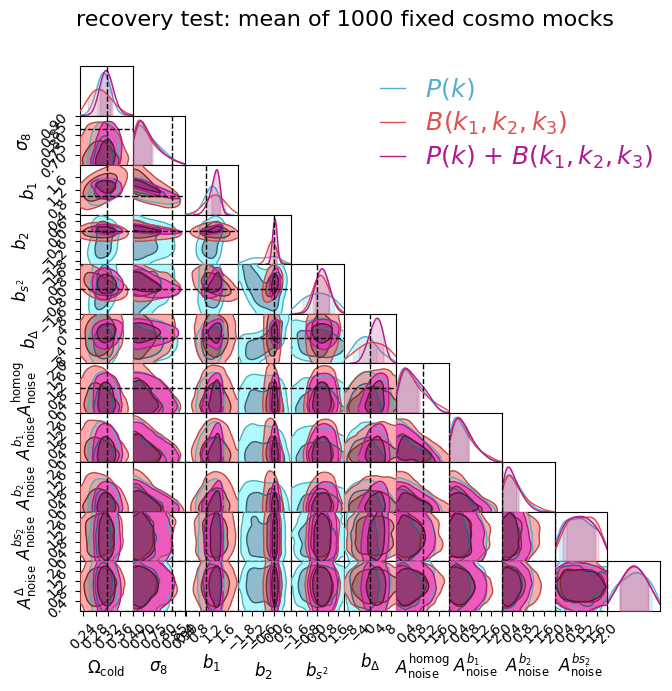

In [11]:
print(param_names_vary)
idx_obs = 0
title = f'recovery test: mean of 1000 fixed cosmo mocks'
tags_stats = [f'_{"_".join(statistics)}' for statistics in statistics_arr]
tags_test = ['_'+data_mode + tag_stats_arr[i] + tag_mask_arr[i] + tag_params_test_fixed + tag_biasparams_test_fixed + tag_noise_fixed + tag_Anoise_fixed + '_mean' for i in range(len(tag_stats_arr))]

#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
# doing utils.biasparam_names_ordered here instead of bias_param_names_vary in case some param sets don't vary all the bias params but we want to show them on the same plot
#param_names_contour = cosmo_param_names_vary + noise_param_names_vary
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered + noise_param_names_vary
theta_test_show = theta_test_fixed[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]

plotter.plot_contours_inf(param_names_contour, idx_obs, theta_test_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents)

### Inference results: shame

In [12]:
# load fixed-cosmo test set
data_mode_test = 'shame'
tag_mock = '_nbar0.00022'
theta_test = data_loader.load_theta_ood(data_mode_test, tag_mock, 
                                cosmo_param_names_vary=cosmo_param_names_vary, bias_param_names_vary=bias_param_names_vary, noise_param_names_vary=noise_param_names_vary)
print(theta_test)

# get bounds
_, dict_bounds_cosmo, _ = genp.define_LH_cosmo(tag_params)
_, dict_bounds_bias, _ = genp.define_LH_bias(tag_biasparams)
_, dict_bounds_Anoise, _ = genp.define_LH_Anoise(tag_Anoise)
extents = {**dict_bounds_cosmo, **dict_bounds_bias, **dict_bounds_Anoise}

[ 0.3089      0.81590003  0.6774      0.0486      0.9667      0.47410742
  0.03175373 -0.16940883 -0.82443643         nan         nan         nan
         nan         nan]


['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1', 'An_b2', 'An_bs2', 'An_bl']
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_shame_pk_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_bispec_kmaxbispec0.2_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_shame_bispec_kmaxbispec0.2_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_kmaxbispec0.2_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_shame_pk_bispec_kmaxbispec0.2_nbar0.00022_pred.npy


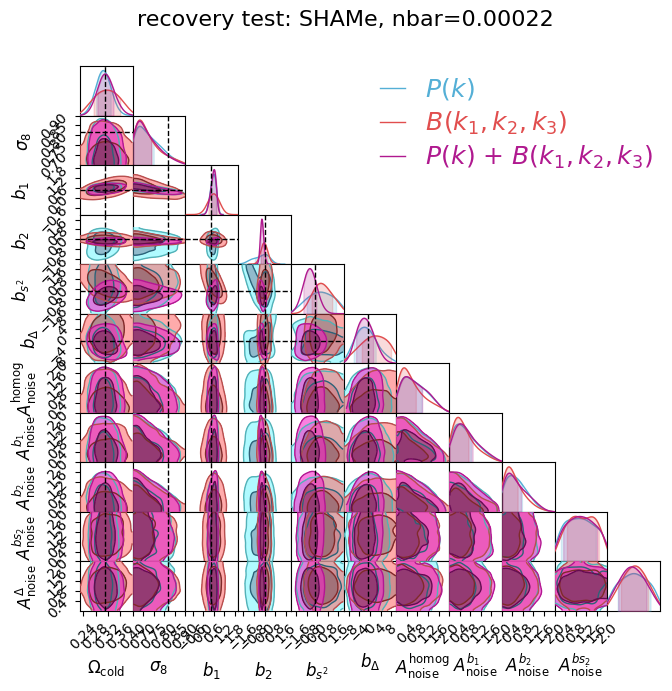

In [13]:
print(param_names_vary)
idx_obs = 0
title = f'recovery test: SHAMe, nbar={tag_mock.split("nbar")[-1]}'
tags_test = ['_'+data_mode_test + tag_stats_arr[i] + tag_mask_arr[i] + tag_mock for i in range(len(tag_stats_arr))]

#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
# doing utils.biasparam_names_ordered here instead of bias_param_names_vary in case some param sets don't vary all the bias params but we want to show them on the same plot
#param_names_contour = cosmo_param_names_vary + noise_param_names_vary
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered + noise_param_names_vary
theta_test_show = theta_test[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]

plotter.plot_contours_inf(param_names_contour, idx_obs, theta_test_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents)

# inference: kmax=0.25 for bispec

## load training: Anmult p5

In [43]:
data_mode = 'muchisimocks'
tag_params = '_p5_n10000'
tag_biasparams = '_biaszen_p4_n200000'
tag_noise = '_noise_unit_p5_n10000'
tag_Anoise = '_Anmult_p5_n200000'

n_train = 10000
#statistics_arr = [['pk']]
statistics_arr = [['pk'], ['bispec'], ['pk', 'bispec']]
tag_stats_arr = [f'_{"_".join(statistics)}' for statistics in statistics_arr]
tag_mask_arr = ['', '_kmaxbispec0.25', '_kmaxbispec0.25']

# muchisimocks_pk_p5_n10000_biaszen_p4_n10000_ntrain10000
tags_inf = [
             f'_{data_mode}{tag_stats_arr[i]}{tag_mask_arr[i]}{tag_params}{tag_biasparams}{tag_noise}{tag_Anoise}_ntrain{n_train}' for i in range(len(tag_stats_arr))
            ]
inf_methods = ['sbi']*len(tags_inf)
labels = [utils.get_stat_label(stat) for stat in statistics_arr]
color_pk = '#54afd6'
color_bispec = "#e14e4e"
color_pkbispec = '#b0198f'
colors = [color_pk, color_bispec, color_pkbispec]

In [44]:
# load training set parameters 
params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, Anoise_df, Anoise_dict_fixed, random_ints, random_ints_bias = data_loader.load_params(tag_params, tag_biasparams, tag_Anoise=tag_Anoise)

# for muchisimocks, we will probably want to vary the same params as the training data
cosmo_param_names_vary, bias_param_names_vary, noise_param_names_vary = [], [], []
if params_df is not None:
    cosmo_param_names_vary = params_df.columns.tolist()
# TODO should this be test or train?
if biasparams_df is not None:
    bias_param_names_vary = biasparams_df.columns.tolist()
if Anoise_df is not None:
    noise_param_names_vary = Anoise_df.columns.tolist()
param_names_vary = cosmo_param_names_vary + bias_param_names_vary + noise_param_names_vary
param_labels = [utils.param_label_dict[param_name] for param_name in param_names_vary]
print(param_names_vary)

['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1', 'An_b2', 'An_bs2', 'An_bl']


### Inference results: cosmic variance / fixed cosmo (quijote)

In [4]:
# load fixed-cosmo test set
tag_params_test_fixed = '_quijote_p0_n1000'
tag_biasparams_test_fixed = '_b1000_p0_n1'
tag_noise_fixed = '_noise_unit_quijote_p0_n1000'
tag_Anoise_fixed = '_Anmult_p0_n1'
theta_test_fixed = data_loader.load_theta_test(tag_params_test_fixed, tag_biasparams_test_fixed, 
                                               tag_Anoise_test=tag_Anoise_fixed,
                                cosmo_param_names_vary=cosmo_param_names_vary, bias_param_names_vary=bias_param_names_vary,
                                noise_param_names_vary=noise_param_names_vary)
print(theta_test_fixed)
print(len(theta_test_fixed))

# get bounds
_, dict_bounds_cosmo, _ = genp.define_LH_cosmo(tag_params_test_fixed)
_, dict_bounds_bias, _ = genp.define_LH_bias(tag_biasparams_test_fixed)
_, dict_bounds_Anoise, _ = genp.define_LH_Anoise(tag_Anoise_fixed)
extents = {**dict_bounds_cosmo, **dict_bounds_bias, **dict_bounds_Anoise}

tag_Anoise_test _Anmult_p0_n1
['An_homog', 'An_b1', 'An_b2', 'An_bs2', 'An_bl']
{'An_homog': 1.0, 'An_b1': 0.0, 'An_b2': 0.0, 'An_bs2': 0.0, 'An_bl': 0.0}
here
14
[0.3175 0.834  0.6711 0.049  0.9624 1.     0.     0.     0.     1.
 0.     0.     0.     0.    ]
14


['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1', 'An_b2', 'An_bs2', 'An_bl']
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_muchisimocks_pk_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_bispec_kmaxbispec0.25_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_muchisimocks_bispec_kmaxbispec0.25_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_kmaxbispec0.25_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_muchisimocks_pk_bispec_kmaxbispec0.25_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy


Parameter b2 in chain $P(k)$ is not constrained
Parameter An_bl in chain $B(k_1,k_2,k_3)$ is not constrained


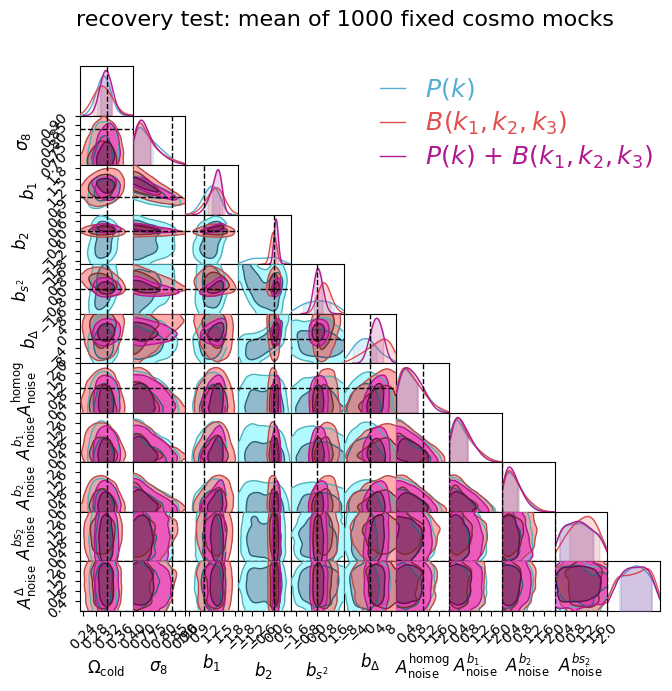

In [5]:
print(param_names_vary)
idx_obs = 0
title = f'recovery test: mean of 1000 fixed cosmo mocks'
tags_stats = [f'_{"_".join(statistics)}' for statistics in statistics_arr]
tags_test = ['_'+data_mode + tag_stats_arr[i] + tag_mask_arr[i] + tag_params_test_fixed + tag_biasparams_test_fixed + tag_noise_fixed + tag_Anoise_fixed + '_mean' for i in range(len(tag_stats_arr))]

#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
# doing utils.biasparam_names_ordered here instead of bias_param_names_vary in case some param sets don't vary all the bias params but we want to show them on the same plot
#param_names_contour = cosmo_param_names_vary + noise_param_names_vary
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered + noise_param_names_vary
theta_test_show = theta_test_fixed[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]

plotter.plot_contours_inf(param_names_contour, idx_obs, theta_test_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents)

['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1', 'An_b2', 'An_bs2', 'An_bl']
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_muchisimocks_pk_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_bispec_kmaxbispec0.25_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_muchisimocks_bispec_kmaxbispec0.25_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_kmaxbispec0.25_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_muchisimocks_pk_bispec_kmaxbispec0.25_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy


Parameter b2 in chain $P(k)$ is not constrained


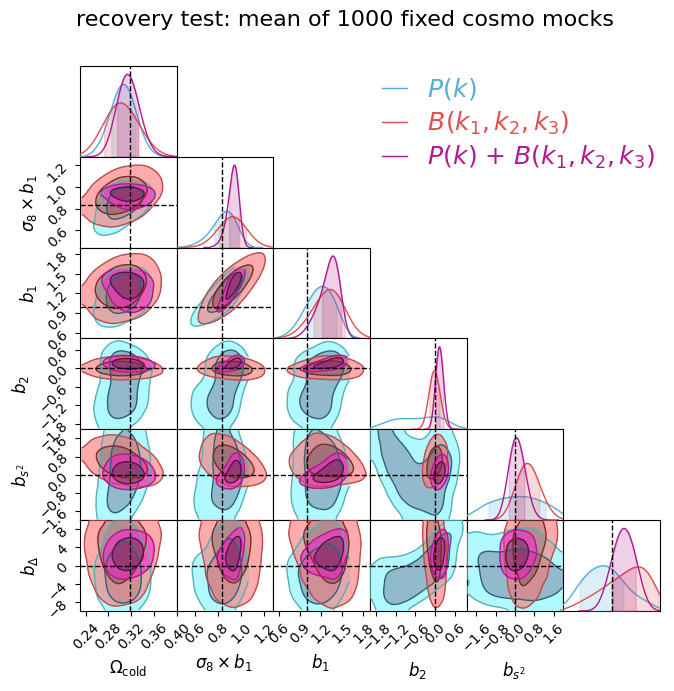

In [6]:
print(param_names_vary)
idx_obs = 0
title = f'recovery test: mean of 1000 fixed cosmo mocks'
tags_stats = [f'_{"_".join(statistics)}' for statistics in statistics_arr]
tags_test = ['_'+data_mode + tag_stats_arr[i] + tag_mask_arr[i] + tag_params_test_fixed + tag_biasparams_test_fixed + tag_noise_fixed + tag_Anoise_fixed + '_mean' for i in range(len(tag_stats_arr))]

#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
# doing utils.biasparam_names_ordered here instead of bias_param_names_vary in case some param sets don't vary all the bias params but we want to show them on the same plot
#param_names_contour = cosmo_param_names_vary + noise_param_names_vary
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered
theta_test_show = theta_test_fixed[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]

plotter.plot_contours_inf_reparam(param_names_contour, idx_obs, theta_test_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents,
                        reparameterize=True,
                        params_show_reparameterize=['sigma8xb1', 'b1'])

['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1', 'An_b2', 'An_bs2', 'An_bl']
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_muchisimocks_pk_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_bispec_kmaxbispec0.25_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_muchisimocks_bispec_kmaxbispec0.25_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_kmaxbispec0.25_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_muchisimocks_pk_bispec_kmaxbispec0.25_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy


Parameter b2 in chain $P(k)$ is not constrained
Parameter An_bl in chain $B(k_1,k_2,k_3)$ is not constrained


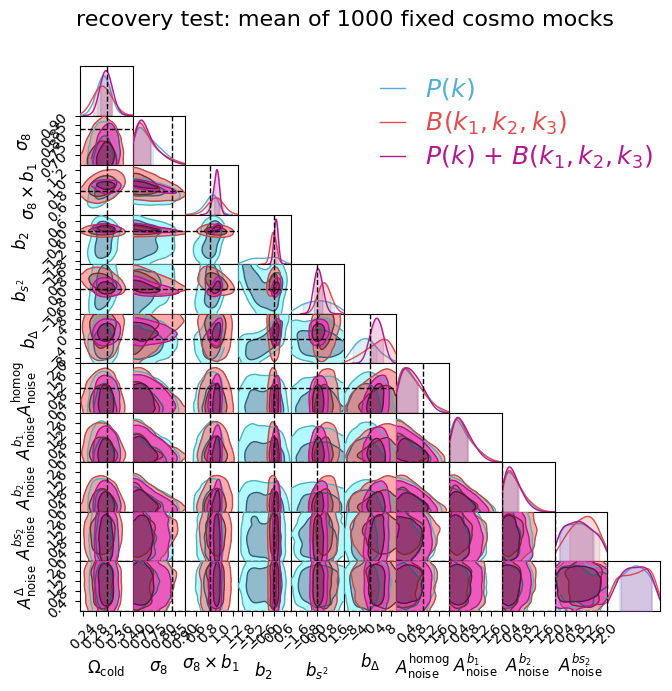

In [7]:
print(param_names_vary)
idx_obs = 0
title = f'recovery test: mean of 1000 fixed cosmo mocks'
tags_stats = [f'_{"_".join(statistics)}' for statistics in statistics_arr]
tags_test = ['_'+data_mode + tag_stats_arr[i] + tag_mask_arr[i] + tag_params_test_fixed + tag_biasparams_test_fixed + tag_noise_fixed + tag_Anoise_fixed + '_mean' for i in range(len(tag_stats_arr))]

#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
# doing utils.biasparam_names_ordered here instead of bias_param_names_vary in case some param sets don't vary all the bias params but we want to show them on the same plot
#param_names_contour = cosmo_param_names_vary + noise_param_names_vary
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered + noise_param_names_vary
theta_test_show = theta_test_fixed[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]

plotter.plot_contours_inf_reparam(param_names_contour, idx_obs, theta_test_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents, reparameterize=True)

### Inference results: shame

In [8]:
# load fixed-cosmo test set
data_mode_test = 'shame'
tag_mock = '_nbar0.00022'
theta_test = data_loader.load_theta_ood(data_mode_test, tag_mock, 
                                cosmo_param_names_vary=cosmo_param_names_vary, bias_param_names_vary=bias_param_names_vary, noise_param_names_vary=noise_param_names_vary)
print(theta_test)

# get bounds
_, dict_bounds_cosmo, _ = genp.define_LH_cosmo(tag_params)
_, dict_bounds_bias, _ = genp.define_LH_bias(tag_biasparams)
_, dict_bounds_Anoise, _ = genp.define_LH_Anoise(tag_Anoise)
extents = {**dict_bounds_cosmo, **dict_bounds_bias, **dict_bounds_Anoise}

[ 0.3089      0.81590003  0.6774      0.0486      0.9667      0.47410742
  0.03175373 -0.16940883 -0.82443643         nan         nan         nan
         nan         nan]


['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1', 'An_b2', 'An_bs2', 'An_bl']
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_shame_pk_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_bispec_kmaxbispec0.25_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_shame_bispec_kmaxbispec0.25_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_kmaxbispec0.25_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_shame_pk_bispec_kmaxbispec0.25_nbar0.00022_pred.npy


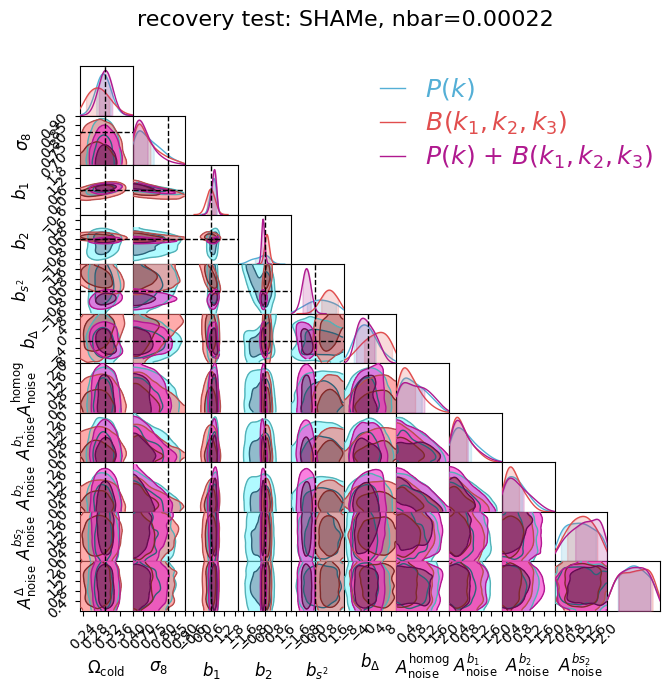

In [9]:
print(param_names_vary)
idx_obs = 0
title = f'recovery test: SHAMe, nbar={tag_mock.split("nbar")[-1]}'
tags_test = ['_'+data_mode_test + tag_stats_arr[i] + tag_mask_arr[i] + tag_mock for i in range(len(tag_stats_arr))]

#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
# doing utils.biasparam_names_ordered here instead of bias_param_names_vary in case some param sets don't vary all the bias params but we want to show them on the same plot
#param_names_contour = cosmo_param_names_vary + noise_param_names_vary
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered + noise_param_names_vary
theta_test_show = theta_test[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]

plotter.plot_contours_inf(param_names_contour, idx_obs, theta_test_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents)

['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1', 'An_b2', 'An_bs2', 'An_bl']
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_shame_pk_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_bispec_kmaxbispec0.25_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_shame_bispec_kmaxbispec0.25_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_kmaxbispec0.25_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_shame_pk_bispec_kmaxbispec0.25_nbar0.00022_pred.npy


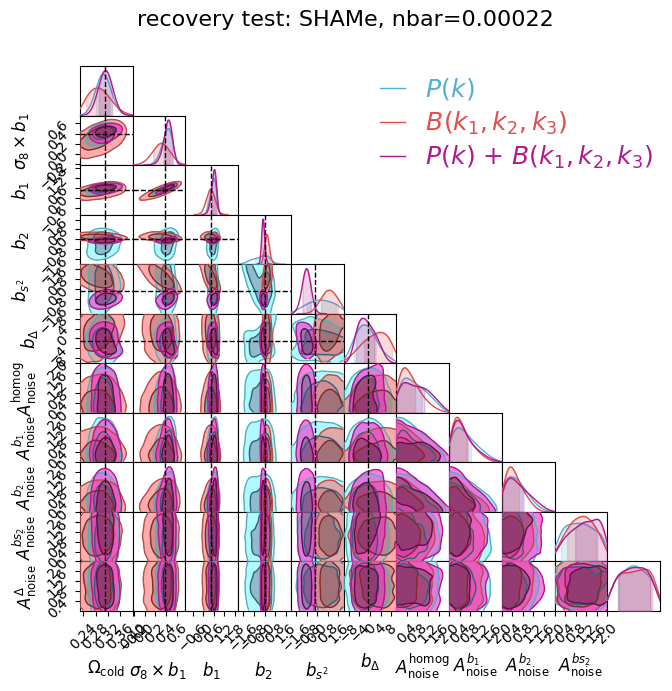

In [10]:
print(param_names_vary)
idx_obs = 0
title = f'recovery test: SHAMe, nbar={tag_mock.split("nbar")[-1]}'
tags_test = ['_'+data_mode_test + tag_stats_arr[i] + tag_mask_arr[i] + tag_mock for i in range(len(tag_stats_arr))]

#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
# doing utils.biasparam_names_ordered here instead of bias_param_names_vary in case some param sets don't vary all the bias params but we want to show them on the same plot
#param_names_contour = cosmo_param_names_vary + noise_param_names_vary
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered + noise_param_names_vary
theta_test_show = theta_test[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]

plotter.plot_contours_inf_reparam(param_names_contour, idx_obs, theta_test_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents, reparameterize=True,
                        params_show_reparameterize=['sigma8xb1', 'b1'])

['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1', 'An_b2', 'An_bs2', 'An_bl']
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_shame_pk_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_bispec_kmaxbispec0.25_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_shame_bispec_kmaxbispec0.25_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_kmaxbispec0.25_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_shame_pk_bispec_kmaxbispec0.25_nbar0.00022_pred.npy


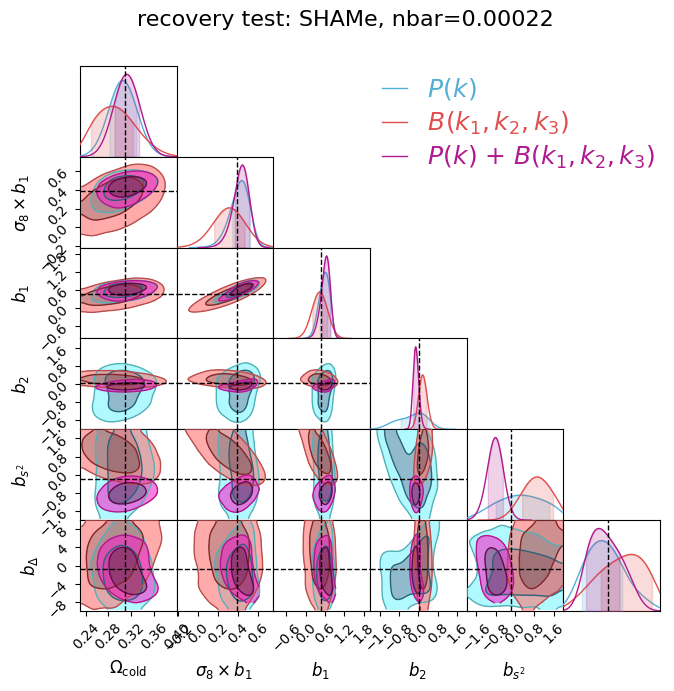

In [11]:
print(param_names_vary)
idx_obs = 0
title = f'recovery test: SHAMe, nbar={tag_mock.split("nbar")[-1]}'
tags_test = ['_'+data_mode_test + tag_stats_arr[i] + tag_mask_arr[i] + tag_mock for i in range(len(tag_stats_arr))]

#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
# doing utils.biasparam_names_ordered here instead of bias_param_names_vary in case some param sets don't vary all the bias params but we want to show them on the same plot
#param_names_contour = cosmo_param_names_vary + noise_param_names_vary
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered
theta_test_show = theta_test[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]

plotter.plot_contours_inf_reparam(param_names_contour, idx_obs, theta_test_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents, reparameterize=True,
                        params_show_reparameterize=['sigma8xb1', 'b1'])

### inference results: coverage test set

In [45]:
# load test set matched to training sest
tag_params_test = '_test_p5_n1000'
tags_biasparams_test = ['_biaszen_p4_n1000']*len(tags_inf)
tags_noise_test = ['_noise_unit_test_p5_n1000']*len(tags_inf)
tags_Anoise_test = ['_Anmult_p5_n1000']*len(tags_inf)
tags_mask_test = ['', '_kmaxbispec0.25', '_kmaxbispec0.25']
tag_datagen_test = ''               

tags_data_test = ['_'+data_mode + tag_stats_arr[i] + tags_mask_test[i] + tag_params_test + tags_biasparams_test[i] + tags_noise_test[i] + tags_Anoise_test[i] + tag_datagen_test for i in range(len(tag_stats_arr))]

for tag_data_test in tags_data_test:
    print(tag_data_test)

_muchisimocks_pk_test_p5_n1000_biaszen_p4_n1000_noise_unit_test_p5_n1000_Anmult_p5_n1000
_muchisimocks_bispec_kmaxbispec0.25_test_p5_n1000_biaszen_p4_n1000_noise_unit_test_p5_n1000_Anmult_p5_n1000
_muchisimocks_pk_bispec_kmaxbispec0.25_test_p5_n1000_biaszen_p4_n1000_noise_unit_test_p5_n1000_Anmult_p5_n1000


In [46]:
#param_names_show = cosmo_param_names_vary + utils.biasparam_names_ordered
param_names_show = utils.param_names_all_ordered
#param_names_show = cosmo_param_names_vary + ['b1']
theta_true_arr, theta_pred_arr, vars_pred_arr = [], [], []
covs_pred_arr = [] #note that this will be for all params, not just show, for now
for i, tag_inf in enumerate(tags_inf):

    _theta_test_pred, _covs_test_pred, param_names  = utils.get_moments_test_sbi(tag_inf, tag_test=tags_data_test[i],
                                                                     #param_names=param_names_show
                                                                     )
    theta_test = data_loader.load_theta_test(tag_params_test, tags_biasparams_test[i])
    theta_true_inf, theta_pred_inf, vars_pred_inf = [], [], []
    for param_name_show in param_names_show:
        if param_name_show in param_names:
            idx_pn = list(param_names).index(param_name_show)
            theta_true_inf.append(theta_test[:,idx_pn])
            theta_pred_inf.append(_theta_test_pred[:,idx_pn])
            vars_pred_inf.append(_covs_test_pred[:,idx_pn,idx_pn])
            #covs_pred_arr.append(_covs_test_pred[:,idx_pn,idx_pn])
        else:
            nans = np.full(_theta_test_pred.shape[0], np.nan)
            theta_true_inf.append(nans)
            theta_pred_inf.append(nans)
            vars_pred_inf.append(nans)
            #covs_pred_arr.append(None)

    theta_true_arr.append(np.array(theta_true_inf).T)
    theta_pred_arr.append(np.array(theta_pred_inf).T)
    vars_pred_arr.append(np.array(vars_pred_inf).T)
    covs_pred_arr.append(_covs_test_pred)
    
theta_true_arr = np.array(theta_true_arr)
theta_pred_arr = np.array(theta_pred_arr)
vars_pred_arr = np.array(vars_pred_arr)
covs_pred_arr = np.array(covs_pred_arr)

1000
1000
1000


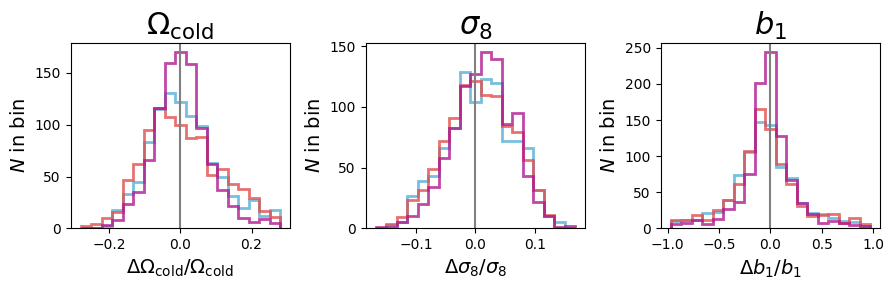

(3, 1000, 9)
omega_cold: 1.260 (0.107 / 0.085)
sigma8_cold: 1.127 (0.056 / 0.050)
b1: 1.144 (5.949 / 5.200)


In [47]:
param_names_key = ['omega_cold', 'sigma8_cold', 'b1']
fracdiffs_arr = plotter.plot_dists_mean_subplots(theta_pred_arr, theta_true_arr, param_names_show, param_names_plot=param_names_key, param_label_dict=utils.param_label_dict,
                        color_arr=colors, label_arr=labels,
                        n_bins=20, alpha=0.8, histtype='step',
                        xlim_auto=False,
                        plot_cdf=False)
print(fracdiffs_arr.shape)
for param_name in param_names_key:
    std_fracdiffs_pk = np.std(fracdiffs_arr[0,:,param_names_show.index(param_name)])
    std_fracdiffs_pk_bispec = np.std(fracdiffs_arr[2,:,param_names_show.index(param_name)])
    improvement = std_fracdiffs_pk / std_fracdiffs_pk_bispec
    print(f'{param_name}: {improvement:.3f} ({std_fracdiffs_pk:.3f} / {std_fracdiffs_pk_bispec:.3f})')
                        

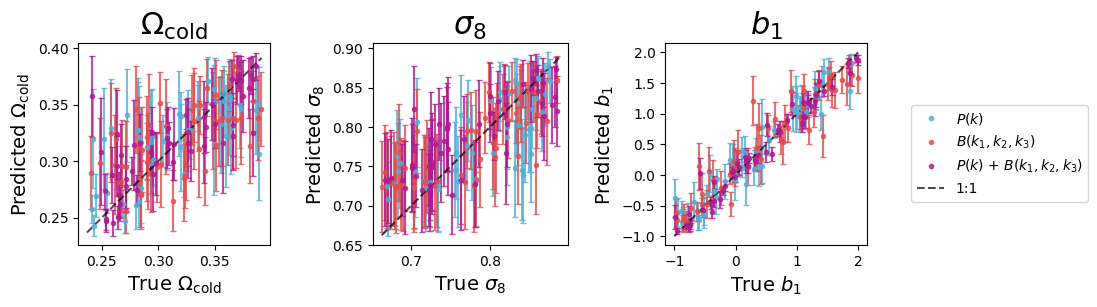

In [48]:
param_names_key = ['omega_cold', 'sigma8_cold', 'b1']
fracdiffs_arr = plotter.plot_comp_mean_subplots(theta_pred_arr, theta_true_arr, covs_pred_arr, param_names_show, param_names_plot=param_names_key, param_label_dict=utils.param_label_dict,
                        color_arr=colors, label_arr=labels,
                        alpha=0.8, N_plot=50)

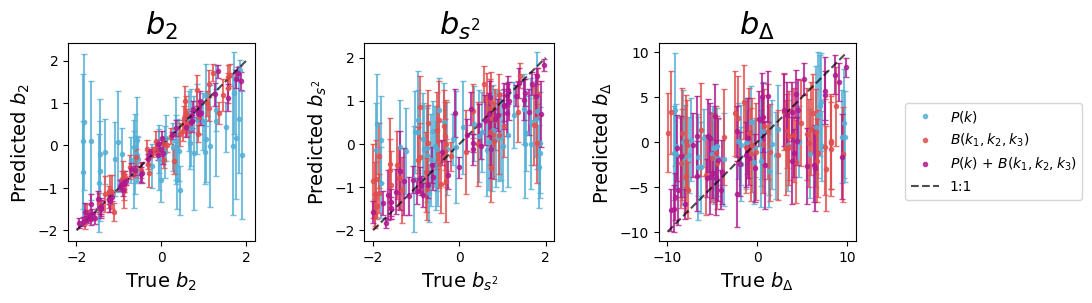

In [49]:
param_names_key = ['b2', 'bs2', 'bl']
fracdiffs_arr = plotter.plot_comp_mean_subplots(theta_pred_arr, theta_true_arr, covs_pred_arr, param_names_show, param_names_plot=param_names_key, param_label_dict=utils.param_label_dict,
                        color_arr=colors, label_arr=labels,
                        alpha=0.8, N_plot=50)

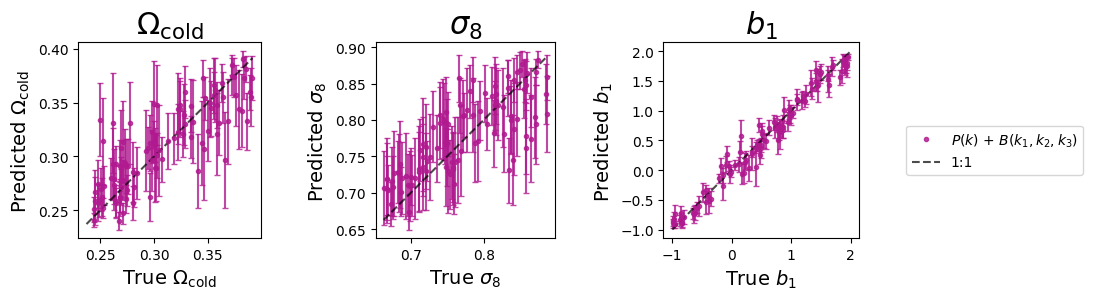

In [23]:
param_names_key = ['omega_cold', 'sigma8_cold', 'b1']
idx_stat = 2 # p+b
fracdiffs_arr = plotter.plot_comp_mean_subplots(theta_pred_arr[idx_stat], theta_true_arr[idx_stat], covs_pred_arr[idx_stat], param_names_show, param_names_plot=param_names_key, param_label_dict=utils.param_label_dict,
                        color_arr=[colors[idx_stat]], label_arr=[labels[idx_stat]],
                        alpha=0.8, N_plot=100)

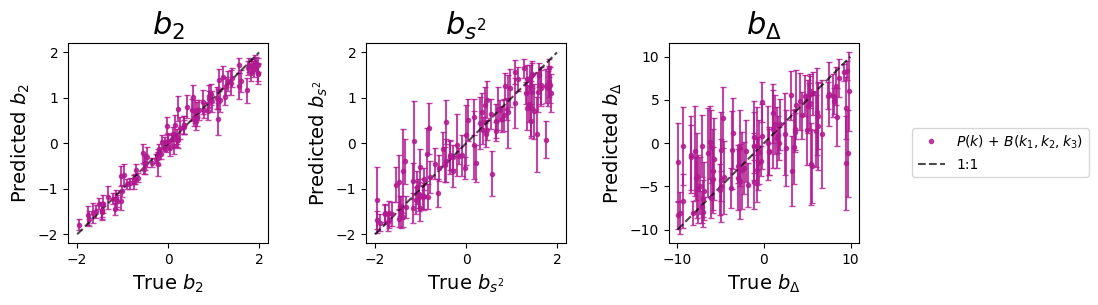

In [24]:
param_names_key = ['b2', 'bs2', 'bl']
idx_stat = 2 # p+b
fracdiffs_arr = plotter.plot_comp_mean_subplots(theta_pred_arr[idx_stat], theta_true_arr[idx_stat], covs_pred_arr[idx_stat], param_names_show, param_names_plot=param_names_key, param_label_dict=utils.param_label_dict,
                        color_arr=[colors[idx_stat]], label_arr=[labels[idx_stat]],
                        alpha=0.8, N_plot=100)

# Inference: kmax=0.3 for bispec

## load training: Anmult p2

In [17]:
data_mode = 'muchisimocks'
tag_params = '_p5_n10000'
tag_biasparams = '_biaszen_p4_n200000'
tag_noise = '_noise_unit_p5_n10000'
tag_Anoise = '_Anmult_p2_n200000'

n_train = 10000
#statistics_arr = [['pk']]
#statistics_arr = [['pk'], ['bispec']]
statistics_arr = [['pk'], ['bispec'], ['pk', 'bispec']]
tag_stats_arr = [f'_{"_".join(statistics)}' for statistics in statistics_arr]
tag_mask_arr = ['', '_kmaxbispec0.3', '_kmaxbispec0.3']

# muchisimocks_pk_p5_n10000_biaszen_p4_n10000_ntrain10000
tags_inf = [
             f'_{data_mode}{tag_stats_arr[i]}{tag_mask_arr[i]}{tag_params}{tag_biasparams}{tag_noise}{tag_Anoise}_ntrain{n_train}' for i in range(len(tag_stats_arr))
            ]
inf_methods = ['sbi']*len(tags_inf)
labels = [utils.get_stat_label(stat) for stat in statistics_arr]
color_pk = '#54afd6'
color_bispec = "#e14e4e"
color_pkbispec = '#b0198f'
colors = [color_pk, color_bispec, color_pkbispec]

In [18]:
# load training set parameters 
params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, Anoise_df, Anoise_dict_fixed, random_ints, random_ints_bias = data_loader.load_params(tag_params, tag_biasparams, tag_Anoise=tag_Anoise)

# for muchisimocks, we will probably want to vary the same params as the training data
cosmo_param_names_vary, bias_param_names_vary, noise_param_names_vary = [], [], []
if params_df is not None:
    cosmo_param_names_vary = params_df.columns.tolist()
# TODO should this be test or train?
if biasparams_df is not None:
    bias_param_names_vary = biasparams_df.columns.tolist()
if Anoise_df is not None:
    noise_param_names_vary = Anoise_df.columns.tolist()
param_names_vary = cosmo_param_names_vary + bias_param_names_vary + noise_param_names_vary
param_labels = [utils.param_label_dict[param_name] for param_name in param_names_vary]
print(param_names_vary)

['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1']


### Inference results: cosmic variance / fixed cosmo (quijote)

In [19]:
# load fixed-cosmo test set
tag_params_test_fixed = '_quijote_p0_n1000'
tag_biasparams_test_fixed = '_b1000_p0_n1'
tag_noise_fixed = '_noise_unit_quijote_p0_n1000'
tag_Anoise_fixed = '_Anmult_p0_n1'
theta_test_fixed = data_loader.load_theta_test(tag_params_test_fixed, tag_biasparams_test_fixed, 
                                               tag_Anoise_test=tag_Anoise_fixed,
                                cosmo_param_names_vary=cosmo_param_names_vary, bias_param_names_vary=bias_param_names_vary,
                                noise_param_names_vary=noise_param_names_vary)
print(theta_test_fixed)
print(len(theta_test_fixed))

# get bounds
_, dict_bounds_cosmo, _ = genp.define_LH_cosmo(tag_params_test_fixed)
_, dict_bounds_bias, _ = genp.define_LH_bias(tag_biasparams_test_fixed)
_, dict_bounds_Anoise, _ = genp.define_LH_Anoise(tag_Anoise_fixed)
extents = {**dict_bounds_cosmo, **dict_bounds_bias, **dict_bounds_Anoise}

tag_Anoise_test _Anmult_p0_n1
['An_homog', 'An_b1']
{'An_homog': 1.0, 'An_b1': 0.0, 'An_b2': 0.0, 'An_bs2': 0.0, 'An_bl': 0.0}
here
11
[0.3175 0.834  0.6711 0.049  0.9624 1.     0.     0.     0.     1.
 0.    ]
11


['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1']
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p2_n200000_ntrain10000/samples_test_muchisimocks_pk_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_bispec_kmaxbispec0.3_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p2_n200000_ntrain10000/samples_test_muchisimocks_bispec_kmaxbispec0.3_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_kmaxbispec0.3_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p2_n200000_ntrain10000/samples_test_muchisimocks_pk_bispec_kmaxbispec0.3_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy


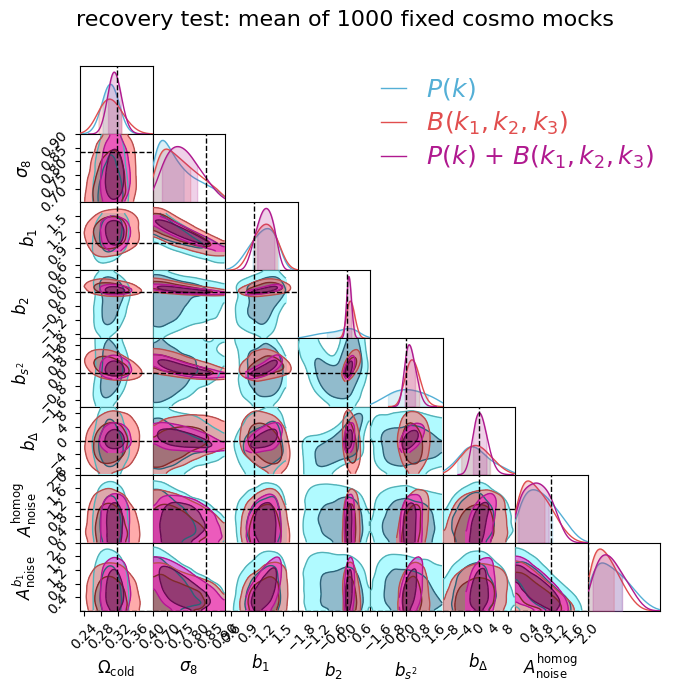

In [20]:
print(param_names_vary)
idx_obs = 0
title = f'recovery test: mean of 1000 fixed cosmo mocks'
tags_stats = [f'_{"_".join(statistics)}' for statistics in statistics_arr]
tags_test = ['_'+data_mode + tag_stats_arr[i] + tag_mask_arr[i] + tag_params_test_fixed + tag_biasparams_test_fixed + tag_noise_fixed + tag_Anoise_fixed + '_mean' for i in range(len(tag_stats_arr))]

#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
# doing utils.biasparam_names_ordered here instead of bias_param_names_vary in case some param sets don't vary all the bias params but we want to show them on the same plot
#param_names_contour = cosmo_param_names_vary + noise_param_names_vary
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered + noise_param_names_vary
theta_test_show = theta_test_fixed[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]

plotter.plot_contours_inf(param_names_contour, idx_obs, theta_test_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents)

### Inference results: shame

In [21]:
# load fixed-cosmo test set
data_mode_test = 'shame'
tag_mock = '_nbar0.00022'
theta_test = data_loader.load_theta_ood(data_mode_test, tag_mock, 
                                cosmo_param_names_vary=cosmo_param_names_vary, bias_param_names_vary=bias_param_names_vary, noise_param_names_vary=noise_param_names_vary)
print(theta_test)

# get bounds
_, dict_bounds_cosmo, _ = genp.define_LH_cosmo(tag_params)
_, dict_bounds_bias, _ = genp.define_LH_bias(tag_biasparams)
_, dict_bounds_Anoise, _ = genp.define_LH_Anoise(tag_Anoise)
extents = {**dict_bounds_cosmo, **dict_bounds_bias, **dict_bounds_Anoise}

[ 0.3089      0.81590003  0.6774      0.0486      0.9667      0.47410742
  0.03175373 -0.16940883 -0.82443643         nan         nan]


['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1']
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p2_n200000_ntrain10000/samples_test_shame_pk_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_bispec_kmaxbispec0.3_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p2_n200000_ntrain10000/samples_test_shame_bispec_kmaxbispec0.3_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_kmaxbispec0.3_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p2_n200000_ntrain10000/samples_test_shame_pk_bispec_kmaxbispec0.3_nbar0.00022_pred.npy


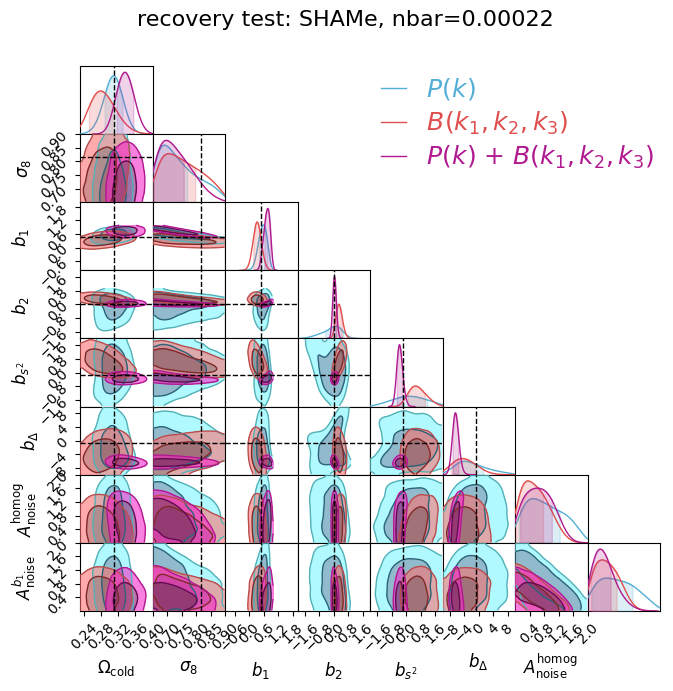

In [22]:
print(param_names_vary)
idx_obs = 0
title = f'recovery test: SHAMe, nbar={tag_mock.split("nbar")[-1]}'
tags_test = ['_'+data_mode_test + tag_stats_arr[i] + tag_mask_arr[i] + tag_mock for i in range(len(tag_stats_arr))]

#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
# doing utils.biasparam_names_ordered here instead of bias_param_names_vary in case some param sets don't vary all the bias params but we want to show them on the same plot
#param_names_contour = cosmo_param_names_vary + noise_param_names_vary
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered + noise_param_names_vary
theta_test_show = theta_test[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]

plotter.plot_contours_inf(param_names_contour, idx_obs, theta_test_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents)

## load training: Anmult p5

In [23]:
data_mode = 'muchisimocks'
tag_params = '_p5_n10000'
tag_biasparams = '_biaszen_p4_n200000'
tag_noise = '_noise_unit_p5_n10000'
tag_Anoise = '_Anmult_p5_n200000'

n_train = 10000
#statistics_arr = [['pk']]
statistics_arr = [['pk'], ['bispec'], ['pk', 'bispec']]
tag_stats_arr = [f'_{"_".join(statistics)}' for statistics in statistics_arr]
tag_mask_arr = ['', '_kmaxbispec0.3', '_kmaxbispec0.3']

# muchisimocks_pk_p5_n10000_biaszen_p4_n10000_ntrain10000
tags_inf = [
             f'_{data_mode}{tag_stats_arr[i]}{tag_mask_arr[i]}{tag_params}{tag_biasparams}{tag_noise}{tag_Anoise}_ntrain{n_train}' for i in range(len(tag_stats_arr))
            ]
inf_methods = ['sbi']*len(tags_inf)
labels = [utils.get_stat_label(stat) for stat in statistics_arr]
color_pk = '#54afd6'
color_bispec = "#e14e4e"
color_pkbispec = '#b0198f'
colors = [color_pk, color_bispec, color_pkbispec]

In [24]:
# load training set parameters 
params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, Anoise_df, Anoise_dict_fixed, random_ints, random_ints_bias = data_loader.load_params(tag_params, tag_biasparams, tag_Anoise=tag_Anoise)

# for muchisimocks, we will probably want to vary the same params as the training data
cosmo_param_names_vary, bias_param_names_vary, noise_param_names_vary = [], [], []
if params_df is not None:
    cosmo_param_names_vary = params_df.columns.tolist()
# TODO should this be test or train?
if biasparams_df is not None:
    bias_param_names_vary = biasparams_df.columns.tolist()
if Anoise_df is not None:
    noise_param_names_vary = Anoise_df.columns.tolist()
param_names_vary = cosmo_param_names_vary + bias_param_names_vary + noise_param_names_vary
param_labels = [utils.param_label_dict[param_name] for param_name in param_names_vary]
print(param_names_vary)

['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1', 'An_b2', 'An_bs2', 'An_bl']


### Inference results: cosmic variance / fixed cosmo (quijote)

In [25]:
# load fixed-cosmo test set
tag_params_test_fixed = '_quijote_p0_n1000'
tag_biasparams_test_fixed = '_b1000_p0_n1'
tag_noise_fixed = '_noise_unit_quijote_p0_n1000'
tag_Anoise_fixed = '_Anmult_p0_n1'
theta_test_fixed = data_loader.load_theta_test(tag_params_test_fixed, tag_biasparams_test_fixed, 
                                               tag_Anoise_test=tag_Anoise_fixed,
                                cosmo_param_names_vary=cosmo_param_names_vary, bias_param_names_vary=bias_param_names_vary,
                                noise_param_names_vary=noise_param_names_vary)
print(theta_test_fixed)
print(len(theta_test_fixed))

# get bounds
_, dict_bounds_cosmo, _ = genp.define_LH_cosmo(tag_params_test_fixed)
_, dict_bounds_bias, _ = genp.define_LH_bias(tag_biasparams_test_fixed)
_, dict_bounds_Anoise, _ = genp.define_LH_Anoise(tag_Anoise_fixed)
extents = {**dict_bounds_cosmo, **dict_bounds_bias, **dict_bounds_Anoise}

tag_Anoise_test _Anmult_p0_n1
['An_homog', 'An_b1', 'An_b2', 'An_bs2', 'An_bl']
{'An_homog': 1.0, 'An_b1': 0.0, 'An_b2': 0.0, 'An_bs2': 0.0, 'An_bl': 0.0}
here
14
[0.3175 0.834  0.6711 0.049  0.9624 1.     0.     0.     0.     1.
 0.     0.     0.     0.    ]
14


['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1', 'An_b2', 'An_bs2', 'An_bl']
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_muchisimocks_pk_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_bispec_kmaxbispec0.3_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_muchisimocks_bispec_kmaxbispec0.3_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_kmaxbispec0.3_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_muchisimocks_pk_bispec_kmaxbispec0.3_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy


Parameter b2 in chain $P(k)$ is not constrained


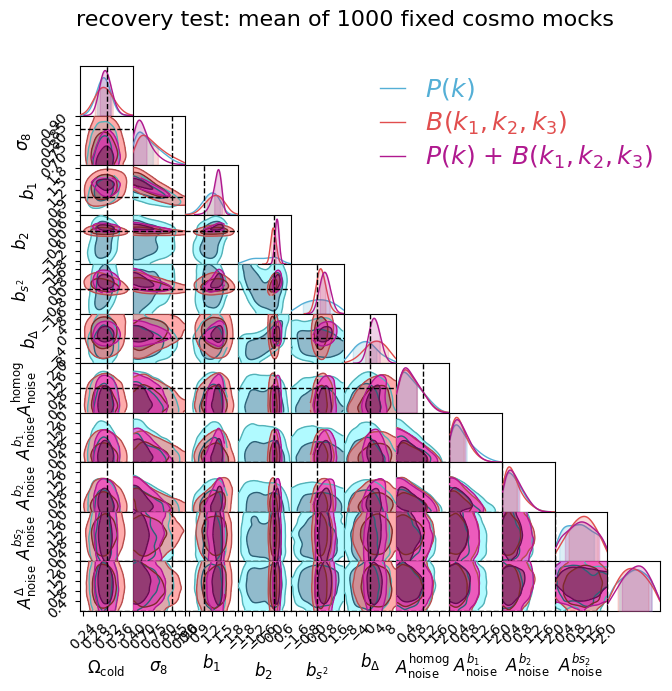

In [26]:
print(param_names_vary)
idx_obs = 0
title = f'recovery test: mean of 1000 fixed cosmo mocks'
tags_stats = [f'_{"_".join(statistics)}' for statistics in statistics_arr]
tags_test = ['_'+data_mode + tag_stats_arr[i] + tag_mask_arr[i] + tag_params_test_fixed + tag_biasparams_test_fixed + tag_noise_fixed + tag_Anoise_fixed + '_mean' for i in range(len(tag_stats_arr))]

#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
# doing utils.biasparam_names_ordered here instead of bias_param_names_vary in case some param sets don't vary all the bias params but we want to show them on the same plot
#param_names_contour = cosmo_param_names_vary + noise_param_names_vary
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered + noise_param_names_vary
theta_test_show = theta_test_fixed[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]

plotter.plot_contours_inf(param_names_contour, idx_obs, theta_test_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents)

### Inference results: shame

In [27]:
# load fixed-cosmo test set
data_mode_test = 'shame'
tag_mock = '_nbar0.00022'
theta_test = data_loader.load_theta_ood(data_mode_test, tag_mock, 
                                cosmo_param_names_vary=cosmo_param_names_vary, bias_param_names_vary=bias_param_names_vary, noise_param_names_vary=noise_param_names_vary)
print(theta_test)

# get bounds
_, dict_bounds_cosmo, _ = genp.define_LH_cosmo(tag_params)
_, dict_bounds_bias, _ = genp.define_LH_bias(tag_biasparams)
_, dict_bounds_Anoise, _ = genp.define_LH_Anoise(tag_Anoise)
extents = {**dict_bounds_cosmo, **dict_bounds_bias, **dict_bounds_Anoise}

[ 0.3089      0.81590003  0.6774      0.0486      0.9667      0.47410742
  0.03175373 -0.16940883 -0.82443643         nan         nan         nan
         nan         nan]


['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1', 'An_b2', 'An_bs2', 'An_bl']
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_shame_pk_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_bispec_kmaxbispec0.3_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_shame_bispec_kmaxbispec0.3_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_kmaxbispec0.3_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_shame_pk_bispec_kmaxbispec0.3_nbar0.00022_pred.npy


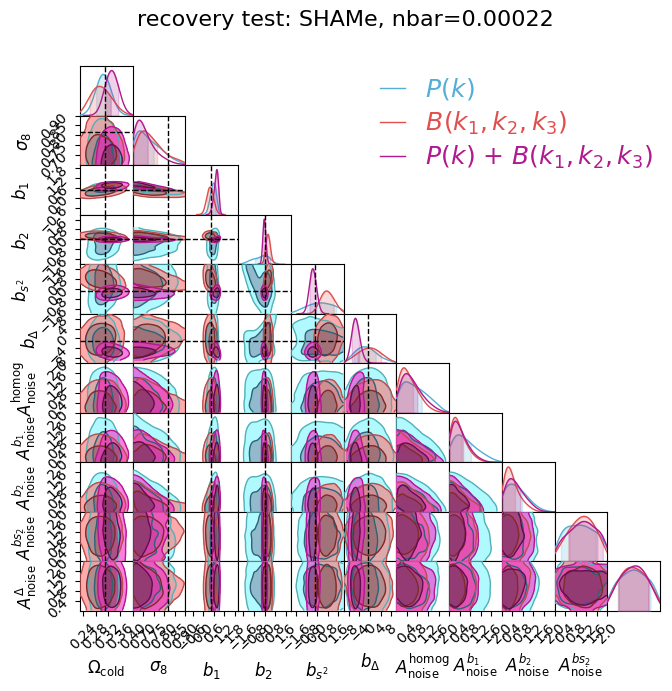

In [28]:
print(param_names_vary)
idx_obs = 0
title = f'recovery test: SHAMe, nbar={tag_mock.split("nbar")[-1]}'
tags_test = ['_'+data_mode_test + tag_stats_arr[i] + tag_mask_arr[i] + tag_mock for i in range(len(tag_stats_arr))]

#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
# doing utils.biasparam_names_ordered here instead of bias_param_names_vary in case some param sets don't vary all the bias params but we want to show them on the same plot
#param_names_contour = cosmo_param_names_vary + noise_param_names_vary
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered + noise_param_names_vary
theta_test_show = theta_test[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]

plotter.plot_contours_inf(param_names_contour, idx_obs, theta_test_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents)

# inference: kmax=0.4 (for p & b)

In [25]:
data_mode = 'muchisimocks'
tag_params = '_p5_n10000'
tag_biasparams = '_biaszen_p4_n200000'
tag_noise = '_noise_unit_p5_n10000'
tag_Anoise = '_Anmult_p5_n200000'

n_train = 10000
#statistics_arr = [['pk']]
statistics_arr = [['pk'], ['bispec'], ['pk', 'bispec']]
tag_stats_arr = [f'_{"_".join(statistics)}' for statistics in statistics_arr]
tag_mask_arr = ['', '', '']

# muchisimocks_pk_p5_n10000_biaszen_p4_n10000_ntrain10000
tags_inf = [
             f'_{data_mode}{tag_stats_arr[i]}{tag_mask_arr[i]}{tag_params}{tag_biasparams}{tag_noise}{tag_Anoise}_ntrain{n_train}' for i in range(len(tag_stats_arr))
            ]
inf_methods = ['sbi']*len(tags_inf)
labels = [utils.get_stat_label(stat) for stat in statistics_arr]
color_pk = '#54afd6'
color_bispec = "#e14e4e"
color_pkbispec = '#b0198f'
colors = [color_pk, color_bispec, color_pkbispec]

In [26]:
# load training set parameters 
params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, Anoise_df, Anoise_dict_fixed, random_ints, random_ints_bias = data_loader.load_params(tag_params, tag_biasparams, tag_Anoise=tag_Anoise)

# for muchisimocks, we will probably want to vary the same params as the training data
cosmo_param_names_vary, bias_param_names_vary, noise_param_names_vary = [], [], []
if params_df is not None:
    cosmo_param_names_vary = params_df.columns.tolist()
# TODO should this be test or train?
if biasparams_df is not None:
    bias_param_names_vary = biasparams_df.columns.tolist()
if Anoise_df is not None:
    noise_param_names_vary = Anoise_df.columns.tolist()
param_names_vary = cosmo_param_names_vary + bias_param_names_vary + noise_param_names_vary
param_labels = [utils.param_label_dict[param_name] for param_name in param_names_vary]
print(param_names_vary)

['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1', 'An_b2', 'An_bs2', 'An_bl']


### Inference results: cosmic variance / fixed cosmo (quijote)

In [27]:
# load fixed-cosmo test set
tag_params_test_fixed = '_quijote_p0_n1000'
tag_biasparams_test_fixed = '_b1000_p0_n1'
tag_noise_fixed = '_noise_unit_quijote_p0_n1000'
tag_Anoise_fixed = '_Anmult_p0_n1'
theta_test_fixed = data_loader.load_theta_test(tag_params_test_fixed, tag_biasparams_test_fixed, 
                                               tag_Anoise_test=tag_Anoise_fixed,
                                cosmo_param_names_vary=cosmo_param_names_vary, bias_param_names_vary=bias_param_names_vary,
                                noise_param_names_vary=noise_param_names_vary)
print(theta_test_fixed)
print(len(theta_test_fixed))

# get bounds
_, dict_bounds_cosmo, _ = genp.define_LH_cosmo(tag_params_test_fixed)
_, dict_bounds_bias, _ = genp.define_LH_bias(tag_biasparams_test_fixed)
_, dict_bounds_Anoise, _ = genp.define_LH_Anoise(tag_Anoise_fixed)
extents = {**dict_bounds_cosmo, **dict_bounds_bias, **dict_bounds_Anoise}

tag_Anoise_test _Anmult_p0_n1
['An_homog', 'An_b1', 'An_b2', 'An_bs2', 'An_bl']
{'An_homog': 1.0, 'An_b1': 0.0, 'An_b2': 0.0, 'An_bs2': 0.0, 'An_bl': 0.0}
here
14
[0.3175 0.834  0.6711 0.049  0.9624 1.     0.     0.     0.     1.
 0.     0.     0.     0.    ]
14


['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1', 'An_b2', 'An_bs2', 'An_bl']
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_muchisimocks_pk_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_bispec_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_muchisimocks_bispec_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_muchisimocks_pk_bispec_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy


Parameter b2 in chain $P(k)$ is not constrained


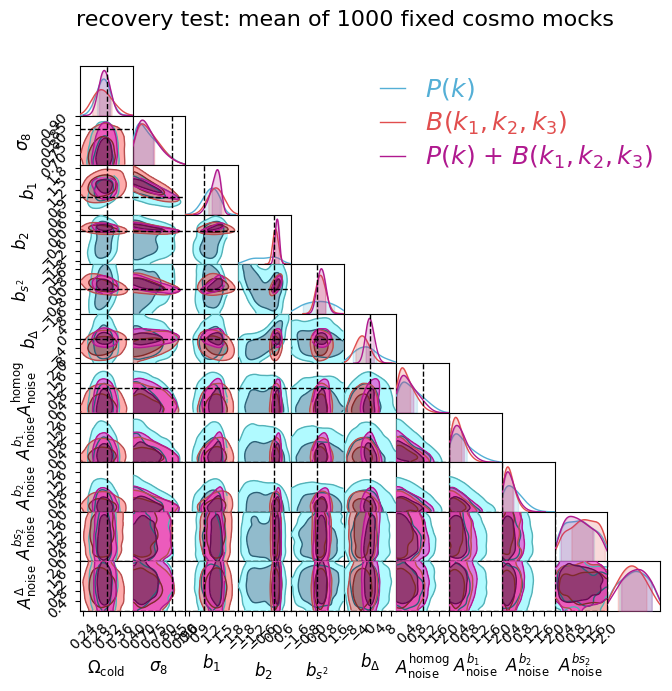

In [28]:
print(param_names_vary)
idx_obs = 0
title = f'recovery test: mean of 1000 fixed cosmo mocks'
tags_stats = [f'_{"_".join(statistics)}' for statistics in statistics_arr]
tags_test = ['_'+data_mode + tag_stats_arr[i] + tag_mask_arr[i] + tag_params_test_fixed + tag_biasparams_test_fixed + tag_noise_fixed + tag_Anoise_fixed + '_mean' for i in range(len(tag_stats_arr))]

#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
# doing utils.biasparam_names_ordered here instead of bias_param_names_vary in case some param sets don't vary all the bias params but we want to show them on the same plot
#param_names_contour = cosmo_param_names_vary + noise_param_names_vary
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered + noise_param_names_vary
theta_test_show = theta_test_fixed[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]

plotter.plot_contours_inf(param_names_contour, idx_obs, theta_test_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents)

### Inference results: shame

In [29]:
# load fixed-cosmo test set
data_mode_test = 'shame'
tag_mock = '_nbar0.00022'
theta_test = data_loader.load_theta_ood(data_mode_test, tag_mock, 
                                cosmo_param_names_vary=cosmo_param_names_vary, bias_param_names_vary=bias_param_names_vary, noise_param_names_vary=noise_param_names_vary)
print(theta_test)

# get bounds
_, dict_bounds_cosmo, _ = genp.define_LH_cosmo(tag_params)
_, dict_bounds_bias, _ = genp.define_LH_bias(tag_biasparams)
_, dict_bounds_Anoise, _ = genp.define_LH_Anoise(tag_Anoise)
extents = {**dict_bounds_cosmo, **dict_bounds_bias, **dict_bounds_Anoise}

[ 0.3089      0.81590003  0.6774      0.0486      0.9667      0.47410742
  0.03175373 -0.16940883 -0.82443643         nan         nan         nan
         nan         nan]


['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1', 'An_b2', 'An_bs2', 'An_bl']
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_shame_pk_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_bispec_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_shame_bispec_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_shame_pk_bispec_nbar0.00022_pred.npy


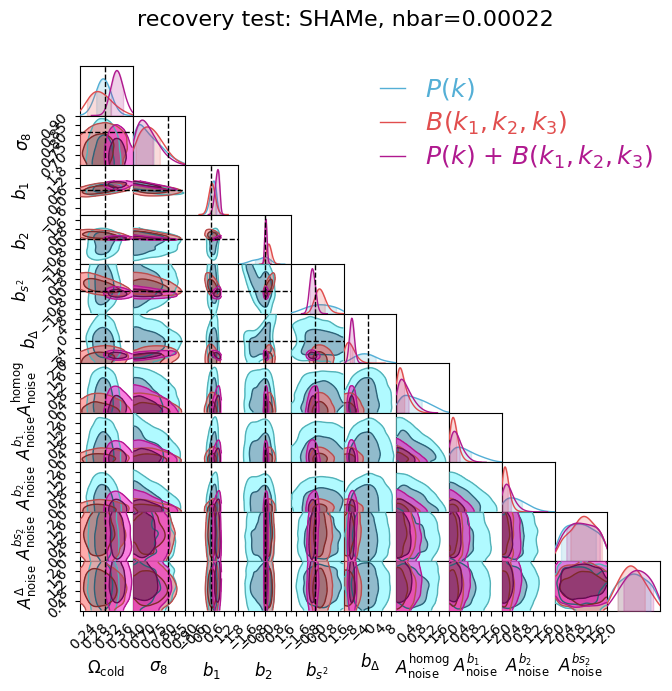

In [30]:
print(param_names_vary)
idx_obs = 0
title = f'recovery test: SHAMe, nbar={tag_mock.split("nbar")[-1]}'
tags_test = ['_'+data_mode_test + tag_stats_arr[i] + tag_mask_arr[i] + tag_mock for i in range(len(tag_stats_arr))]

#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
# doing utils.biasparam_names_ordered here instead of bias_param_names_vary in case some param sets don't vary all the bias params but we want to show them on the same plot
#param_names_contour = cosmo_param_names_vary + noise_param_names_vary
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered + noise_param_names_vary
theta_test_show = theta_test[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]

plotter.plot_contours_inf(param_names_contour, idx_obs, theta_test_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents)

## inference results: coverage test set

In [31]:
# load test set matched to training sest
tag_params_test = '_test_p5_n1000'
tags_biasparams_test = ['_biaszen_p4_n1000']*len(tags_inf)
tags_noise_test = ['_noise_unit_test_p5_n1000']*len(tags_inf)
tags_Anoise_test = ['_Anmult_p5_n1000']*len(tags_inf)
tags_mask_test = ['', '', '']
tag_datagen_test = ''               

tags_data_test = ['_'+data_mode + tag_stats_arr[i] + tags_mask_test[i] + tag_params_test + tags_biasparams_test[i] + tags_noise_test[i] + tags_Anoise_test[i] + tag_datagen_test for i in range(len(tag_stats_arr))]

for tag_data_test in tags_data_test:
    print(tag_data_test)

_muchisimocks_pk_test_p5_n1000_biaszen_p4_n1000_noise_unit_test_p5_n1000_Anmult_p5_n1000
_muchisimocks_bispec_test_p5_n1000_biaszen_p4_n1000_noise_unit_test_p5_n1000_Anmult_p5_n1000
_muchisimocks_pk_bispec_test_p5_n1000_biaszen_p4_n1000_noise_unit_test_p5_n1000_Anmult_p5_n1000


In [32]:
#param_names_show = cosmo_param_names_vary + utils.biasparam_names_ordered
param_names_show = utils.param_names_all_ordered
#param_names_show = cosmo_param_names_vary + ['b1']
theta_true_arr, theta_pred_arr, vars_pred_arr = [], [], []
covs_pred_arr = [] #note that this will be for all params, not just show, for now
for i, tag_inf in enumerate(tags_inf):

    _theta_test_pred, _covs_test_pred, param_names  = utils.get_moments_test_sbi(tag_inf, tag_test=tags_data_test[i],
                                                                     #param_names=param_names_show
                                                                     )
    theta_test = data_loader.load_theta_test(tag_params_test, tags_biasparams_test[i])
    theta_true_inf, theta_pred_inf, vars_pred_inf = [], [], []
    for param_name_show in param_names_show:
        if param_name_show in param_names:
            idx_pn = list(param_names).index(param_name_show)
            theta_true_inf.append(theta_test[:,idx_pn])
            theta_pred_inf.append(_theta_test_pred[:,idx_pn])
            vars_pred_inf.append(_covs_test_pred[:,idx_pn,idx_pn])
            #covs_pred_arr.append(_covs_test_pred[:,idx_pn,idx_pn])
        else:
            nans = np.full(_theta_test_pred.shape[0], np.nan)
            theta_true_inf.append(nans)
            theta_pred_inf.append(nans)
            vars_pred_inf.append(nans)
            #covs_pred_arr.append(None)

    theta_true_arr.append(np.array(theta_true_inf).T)
    theta_pred_arr.append(np.array(theta_pred_inf).T)
    vars_pred_arr.append(np.array(vars_pred_inf).T)
    covs_pred_arr.append(_covs_test_pred)
    
theta_true_arr = np.array(theta_true_arr)
theta_pred_arr = np.array(theta_pred_arr)
vars_pred_arr = np.array(vars_pred_arr)
covs_pred_arr = np.array(covs_pred_arr)

1000
1000
1000


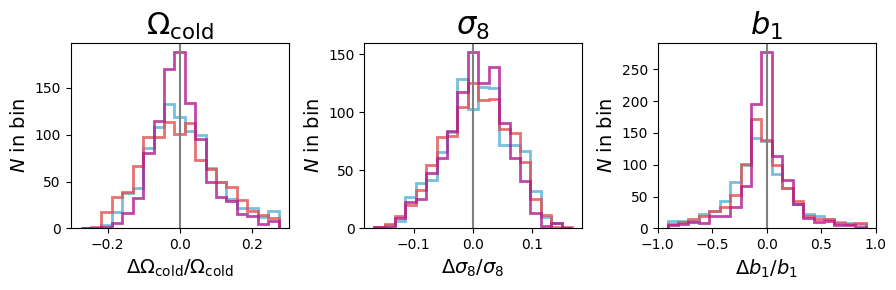

(3, 1000, 9)
omega_cold: 1.302 (0.107 / 0.082)
sigma8_cold: 1.115 (0.056 / 0.050)
b1: 1.144 (5.949 / 5.201)


In [33]:
param_names_key = ['omega_cold', 'sigma8_cold', 'b1']
fracdiffs_arr = plotter.plot_dists_mean_subplots(theta_pred_arr, theta_true_arr, param_names_show, param_names_plot=param_names_key, param_label_dict=utils.param_label_dict,
                        color_arr=colors, label_arr=labels,
                        n_bins=20, alpha=0.8, histtype='step',
                        xlim_auto=False,
                        plot_cdf=False)
print(fracdiffs_arr.shape)
for param_name in param_names_key:
    std_fracdiffs_pk = np.std(fracdiffs_arr[0,:,param_names_show.index(param_name)])
    std_fracdiffs_pk_bispec = np.std(fracdiffs_arr[2,:,param_names_show.index(param_name)])
    improvement = std_fracdiffs_pk / std_fracdiffs_pk_bispec
    print(f'{param_name}: {improvement:.3f} ({std_fracdiffs_pk:.3f} / {std_fracdiffs_pk_bispec:.3f})')
                        

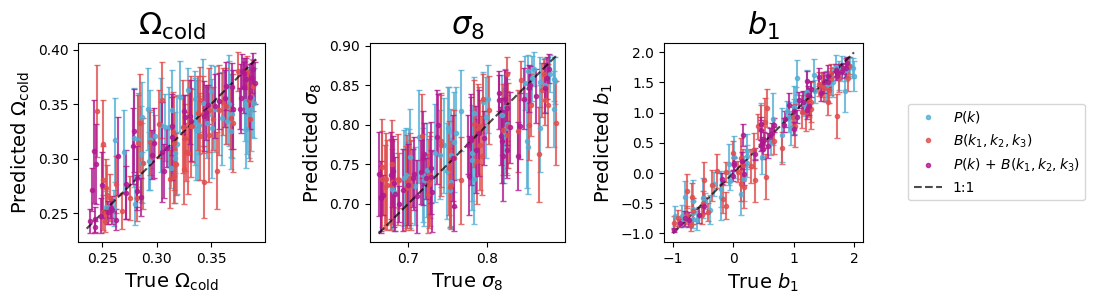

In [34]:
param_names_key = ['omega_cold', 'sigma8_cold', 'b1']
fracdiffs_arr = plotter.plot_comp_mean_subplots(theta_pred_arr, theta_true_arr, covs_pred_arr, param_names_show, param_names_plot=param_names_key, param_label_dict=utils.param_label_dict,
                        color_arr=colors, label_arr=labels,
                        alpha=0.8, N_plot=50)

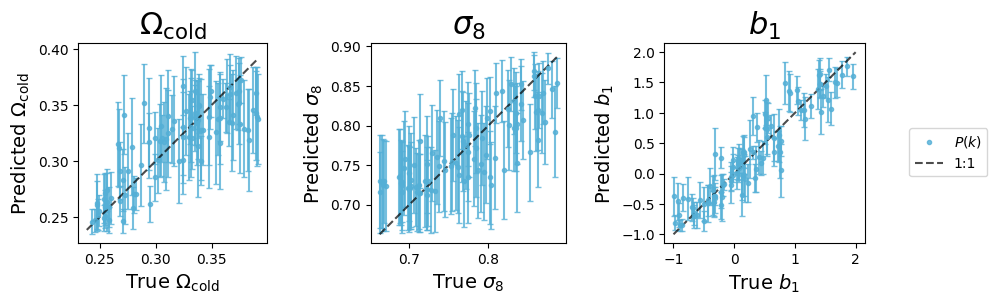

In [ ]:
param_names_key = ['omega_cold', 'sigma8_cold', 'b1']
idx_stat = 0 # p+b
fracdiffs_arr = plotter.plot_comp_mean_subplots(theta_pred_arr[idx_stat], theta_true_arr[idx_stat], covs_pred_arr[idx_stat], param_names_show, param_names_plot=param_names_key, param_label_dict=utils.param_label_dict,
                        color_arr=[colors[idx_stat]], label_arr=[labels[idx_stat]],
                        alpha=0.8, N_plot=100)

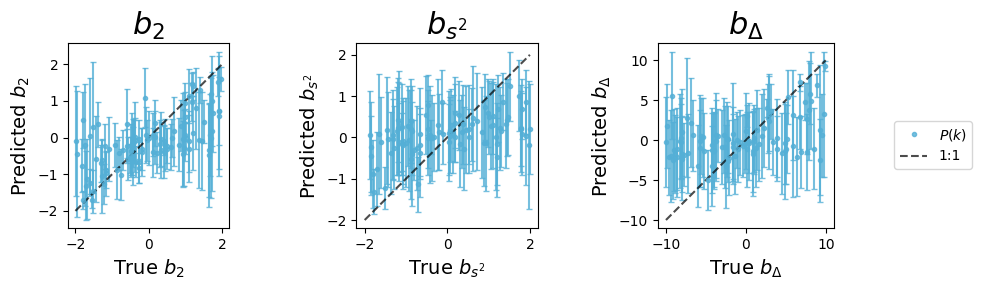

In [39]:
param_names_key = ['b2', 'bs2', 'bl']
idx_stat = 0 # p+b
fracdiffs_arr = plotter.plot_comp_mean_subplots(theta_pred_arr[idx_stat], theta_true_arr[idx_stat], covs_pred_arr[idx_stat], param_names_show, param_names_plot=param_names_key, param_label_dict=utils.param_label_dict,
                        color_arr=[colors[idx_stat]], label_arr=[labels[idx_stat]],
                        alpha=0.8, N_plot=100)

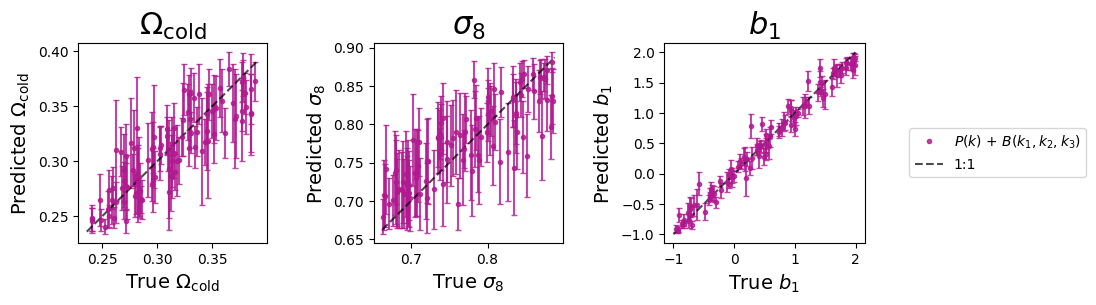

In [35]:
param_names_key = ['omega_cold', 'sigma8_cold', 'b1']
idx_stat = 2 # p+b
fracdiffs_arr = plotter.plot_comp_mean_subplots(theta_pred_arr[idx_stat], theta_true_arr[idx_stat], covs_pred_arr[idx_stat], param_names_show, param_names_plot=param_names_key, param_label_dict=utils.param_label_dict,
                        color_arr=[colors[idx_stat]], label_arr=[labels[idx_stat]],
                        alpha=0.8, N_plot=100)

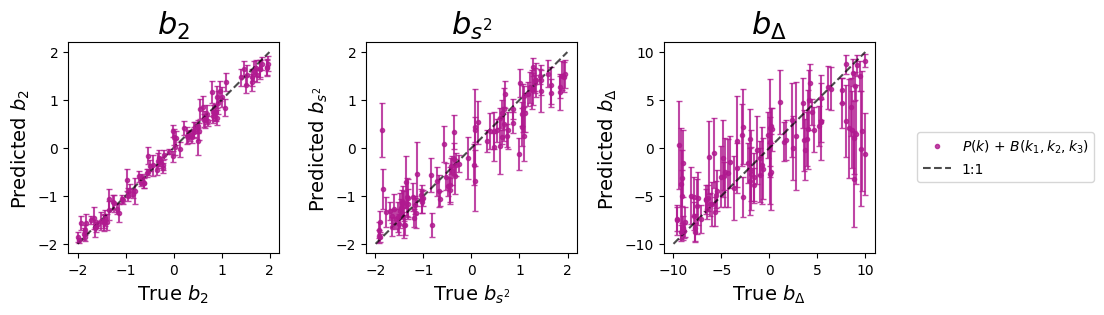

In [ ]:
idx_stat = 2 # p+b
fracdiffs_arr = plotter.plot_comp_mean_subplots(theta_pred_arr[idx_stat], theta_true_arr[idx_stat], covs_pred_arr[idx_stat], param_names_show, param_names_plot=param_names_key, param_label_dict=utils.param_label_dict,
                        color_arr=[colors[idx_stat]], label_arr=[labels[idx_stat]],
                        alpha=0.8, N_plot=100)

# inference: kmax=0.4, noiseless

In [51]:
data_mode = 'muchisimocks'
tag_params = '_p5_n10000'
tag_biasparams = '_biaszen_p4_n200000'
tag_noise = None
tag_Anoise = None

n_train = 10000
statistics_arr = [['pk'], ['bispec'], ['pk', 'bispec']]
tag_stats_arr = [f'_{"_".join(statistics)}' for statistics in statistics_arr]

# muchisimocks_pk_p5_n10000_biaszen_p4_n10000_ntrain10000
if tag_noise is None:
    tags_inf = [f'_{data_mode}{tag_stats}{tag_params}{tag_biasparams}_ntrain{n_train}' for tag_stats in tag_stats_arr]
else:
    tags_inf = [f'_{data_mode}{tag_stats}{tag_params}{tag_biasparams}{tag_noise}{tag_Anoise}_ntrain{n_train}' for tag_stats in tag_stats_arr]
    
inf_methods = ['sbi']*len(tags_inf)
labels = [utils.get_stat_label(stat) for stat in statistics_arr]
color_pk = '#54afd6'
color_bispec = "#e14e4e"
color_pkbispec = '#b0198f'
colors = [color_pk, color_bispec, color_pkbispec]

In [52]:
# load training set parameters 
params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, Anoise_df, Anoise_dict_fixed, random_ints, random_ints_bias = data_loader.load_params(tag_params, tag_biasparams, tag_Anoise=tag_Anoise)

# for muchisimocks, we will probably want to vary the same params as the training data
cosmo_param_names_vary, bias_param_names_vary, noise_param_names_vary = [], [], []
if params_df is not None:
    cosmo_param_names_vary = params_df.columns.tolist()
# TODO should this be test or train?
if biasparams_df is not None:
    bias_param_names_vary = biasparams_df.columns.tolist()
if Anoise_df is not None:
    noise_param_names_vary = Anoise_df.columns.tolist()
param_names_vary = cosmo_param_names_vary + bias_param_names_vary + noise_param_names_vary
param_labels = [utils.param_label_dict[param_name] for param_name in param_names_vary]
print(param_names_vary)

['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl']


### Inference results: cosmic variance / fixed cosmo (quijote)

In [53]:
# load fixed-cosmo test set
tag_params_test_fixed = '_quijote_p0_n1000'
tag_biasparams_test_fixed = '_b1000_p0_n1'
tag_noise_fixed = None
tag_Anoise_fixed = None
theta_test_fixed = data_loader.load_theta_test(tag_params_test_fixed, tag_biasparams_test_fixed, 
                                               tag_Anoise_test=tag_Anoise_fixed,
                                cosmo_param_names_vary=cosmo_param_names_vary, bias_param_names_vary=bias_param_names_vary,
                                noise_param_names_vary=noise_param_names_vary)
print(theta_test_fixed)
print(len(theta_test_fixed))

# get bounds
_, dict_bounds_cosmo, _ = genp.define_LH_cosmo(tag_params_test_fixed)
_, dict_bounds_bias, _ = genp.define_LH_bias(tag_biasparams_test_fixed)
_, dict_bounds_Anoise, _ = genp.define_LH_Anoise(tag_Anoise_fixed)
extents = {**dict_bounds_cosmo, **dict_bounds_bias, **dict_bounds_Anoise}

tag_Anoise_test None
[]
{}
9
[0.3175 0.834  0.6711 0.049  0.9624 1.     0.     0.     0.    ]
9


['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl']
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_ntrain10000/samples_test_muchisimocks_pk_quijote_p0_n1000_b1000_p0_n1_mean_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_bispec_p5_n10000_biaszen_p4_n200000_ntrain10000/samples_test_muchisimocks_bispec_quijote_p0_n1000_b1000_p0_n1_mean_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_p5_n10000_biaszen_p4_n200000_ntrain10000/samples_test_muchisimocks_pk_bispec_quijote_p0_n1000_b1000_p0_n1_mean_pred.npy


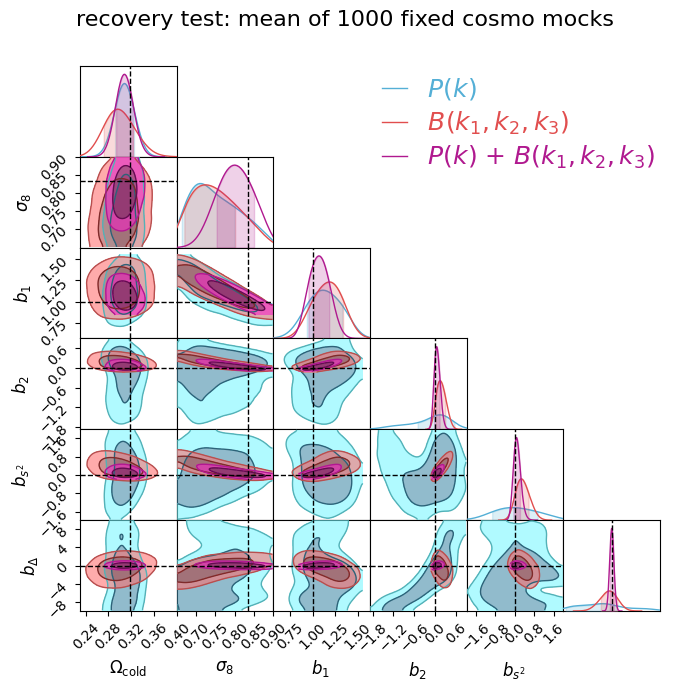

In [54]:
print(param_names_vary)
idx_obs = 0
title = f'recovery test: mean of 1000 fixed cosmo mocks'
tags_stats = [f'_{"_".join(statistics)}' for statistics in statistics_arr]
if tag_noise_fixed is None:
    tags_test = ['_'+data_mode + tag_stats + tag_params_test_fixed + tag_biasparams_test_fixed + '_mean' for tag_stats in tag_stats_arr]
else:
    tags_test = ['_'+data_mode + tag_stats + tag_params_test_fixed + tag_biasparams_test_fixed + tag_noise_fixed + tag_Anoise_fixed + '_mean' for tag_stats in tag_stats_arr]

#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
# doing utils.biasparam_names_ordered here instead of bias_param_names_vary in case some param sets don't vary all the bias params but we want to show them on the same plot
#param_names_contour = cosmo_param_names_vary + noise_param_names_vary
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered + noise_param_names_vary
theta_test_show = theta_test_fixed[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]

plotter.plot_contours_inf(param_names_contour, idx_obs, theta_test_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents)

### inference results: coverage set

In [55]:
# load test set matched to training sest
tag_params_test = '_test_p5_n1000'
tags_biasparams_test = ['_biaszen_p4_n1000']*len(tags_inf)
tags_noise_test = None
tags_Anoise_test = None
tags_mask_test = ['', '', '']
tag_datagen_test = ''               

tags_data_test = ['_'+data_mode + tag_stats_arr[i] + tags_mask_test[i] + tag_params_test + tags_biasparams_test[i] + tag_datagen_test for i in range(len(tag_stats_arr))]

for tag_data_test in tags_data_test:
    print(tag_data_test)

_muchisimocks_pk_test_p5_n1000_biaszen_p4_n1000
_muchisimocks_bispec_test_p5_n1000_biaszen_p4_n1000
_muchisimocks_pk_bispec_test_p5_n1000_biaszen_p4_n1000


In [58]:
#param_names_show = cosmo_param_names_vary + utils.biasparam_names_ordered
param_names_show = utils.param_names_all_ordered
#param_names_show = cosmo_param_names_vary + ['b1']
theta_true_arr, theta_pred_arr, vars_pred_arr = [], [], []
covs_pred_arr = [] #note that this will be for all params, not just show, for now
for i, tag_inf in enumerate(tags_inf):

    _theta_test_pred, _covs_test_pred, param_names  = utils.get_moments_test_sbi(tag_inf, tag_test=tags_data_test[i],
                                                                     #param_names=param_names_show
                                                                     )
    theta_test = data_loader.load_theta_test(tag_params_test, tags_biasparams_test[i])
    theta_true_inf, theta_pred_inf, vars_pred_inf = [], [], []
    for param_name_show in param_names_show:
        if param_name_show in param_names:
            idx_pn = list(param_names).index(param_name_show)
            theta_true_inf.append(theta_test[:,idx_pn])
            theta_pred_inf.append(_theta_test_pred[:,idx_pn])
            vars_pred_inf.append(_covs_test_pred[:,idx_pn,idx_pn])
            #covs_pred_arr.append(_covs_test_pred[:,idx_pn,idx_pn])
        else:
            nans = np.full(_theta_test_pred.shape[0], np.nan)
            theta_true_inf.append(nans)
            theta_pred_inf.append(nans)
            vars_pred_inf.append(nans)
            #covs_pred_arr.append(None)

    theta_true_arr.append(np.array(theta_true_inf).T)
    theta_pred_arr.append(np.array(theta_pred_inf).T)
    vars_pred_arr.append(np.array(vars_pred_inf).T)
    covs_pred_arr.append(_covs_test_pred)
    
theta_true_arr = np.array(theta_true_arr)
theta_pred_arr = np.array(theta_pred_arr)
vars_pred_arr = np.array(vars_pred_arr)
covs_pred_arr = np.array(covs_pred_arr)

fn_samples_test_pred = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_ntrain10000/samples_test_muchisimocks_pk_test_p5_n1000_biaszen_p4_n1000_pred.npy
1000
fn_samples_test_pred = ../results/results_sbi/sbi_muchisimocks_bispec_p5_n10000_biaszen_p4_n200000_ntrain10000/samples_test_muchisimocks_bispec_test_p5_n1000_biaszen_p4_n1000_pred.npy
1000
fn_samples_test_pred = ../results/results_sbi/sbi_muchisimocks_pk_bispec_p5_n10000_biaszen_p4_n200000_ntrain10000/samples_test_muchisimocks_pk_bispec_test_p5_n1000_biaszen_p4_n1000_pred.npy
1000


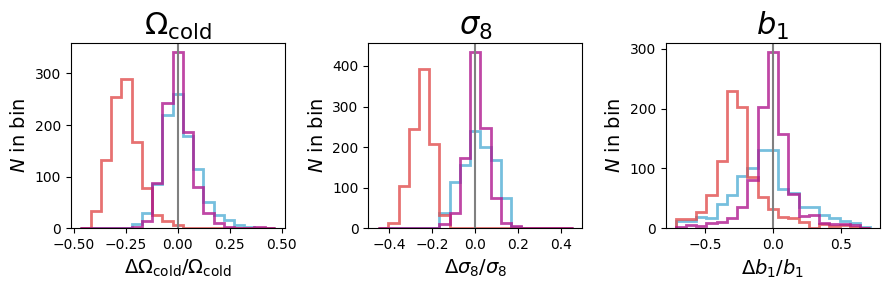

(3, 1000, 9)
omega_cold: 1.298 (0.089 / 0.068)
sigma8_cold: 1.487 (0.074 / 0.050)
b1: 3.617 (7.060 / 1.952)


In [57]:
param_names_key = ['omega_cold', 'sigma8_cold', 'b1']
fracdiffs_arr = plotter.plot_dists_mean_subplots(theta_pred_arr, theta_true_arr, param_names_show, param_names_plot=param_names_key, param_label_dict=utils.param_label_dict,
                        color_arr=colors, label_arr=labels,
                        n_bins=20, alpha=0.8, histtype='step',
                        xlim_auto=False,
                        plot_cdf=False)
print(fracdiffs_arr.shape)
for param_name in param_names_key:
    std_fracdiffs_pk = np.std(fracdiffs_arr[0,:,param_names_show.index(param_name)])
    std_fracdiffs_pk_bispec = np.std(fracdiffs_arr[2,:,param_names_show.index(param_name)])
    improvement = std_fracdiffs_pk / std_fracdiffs_pk_bispec
    print(f'{param_name}: {improvement:.3f} ({std_fracdiffs_pk:.3f} / {std_fracdiffs_pk_bispec:.3f})')
                        

# checking k values

In [14]:
k_min = 0.01
k_max = 0.4
n_bins = 7
k_edges = np.linspace(k_min, k_max, n_bins+1) # 7 bins
print(k_edges)

[0.01       0.06571429 0.12142857 0.17714286 0.23285714 0.28857143
 0.34428571 0.4       ]


In [15]:
statistics = ['bispec']
k_mock_full, y_mock_full, y_err_mock_full = data_loader.load_data_ood(
    data_mode_test, statistics, tag_mock, tag_data=None
)

Loaded bispec with shape (50,)
Loaded bispec data with shape (50,)
No tag_data provided, so not masking data


In [16]:
np.unique(k_mock_full)

array([0.03785714, 0.09357143, 0.14928571, 0.205     , 0.26071429,
       0.31642857, 0.37214286])

# stats

In [3]:
data_mode = 'muchisimocks'
statistics = ['pk', 'bispec']
#statistics = ['pk']

### train
tag_params = '_p5_n10000'
tag_biasparams = '_biaszen_p4_n10000'
tag_noise = '_noise_unit_p5_n10000'
tag_Anoise = '_Anmult_p5_n10000'
### test
# tag_params = '_test_p5_n1000'
# tag_biasparams = '_biaszen_p4_n1000'
# tag_noise = '_noise_unit_test_p5_n1000'
# tag_Anoise = '_Anmult_p5_n1000'
## cosmic variance (quijote)
# tag_params="_quijote_p0_n1000"
# tag_biasparams="_b1000_p0_n1"
# tag_noise="_noise_quijote_p0_n1000"
# tag_Anoise="_An1_p0_n1"
tag_datagen = ''
kwargs_data = {
    'tag_datagen': tag_datagen
}

tag_stats = f'_{"_".join(statistics)}'    
tag_data = '_'+data_mode + tag_stats + tag_params + tag_biasparams + tag_datagen
k_arr_np5, y_arr_np5, y_err_np5, idxs_params_np5, params_df_np5, param_dict_fixed_np5, biasparams_df_np5, biasparams_dict_fixed_np5, Anoise_df_np5, Anoise_dict_fixed_np5, random_ints_np5, random_ints_bias_np5 = \
            data_loader.load_data(data_mode, statistics, 
                                    tag_params, tag_biasparams,
                                    tag_noise=tag_noise, tag_Anoise=tag_Anoise,
                                    tag_data=tag_data,
                                    kwargs=kwargs_data)
            
print(y_arr_np5[0].shape)
#print(y_arr[1].shape)

dir_statistics: /scratch/kstoreyf/muchisimocks/data/pks_mlib/pks_p5_n10000_biaszen_p4_n10000_noise_unit_p5_n10000_Anmult_p5_n10000
Loading muchisimocks data from /scratch/kstoreyf/muchisimocks/data/pks_mlib/pks_p5_n10000_biaszen_p4_n10000_noise_unit_p5_n10000_Anmult_p5_n10000
Found 10000 diff cosmo pks in /scratch/kstoreyf/muchisimocks/data/pks_mlib/pks_p5_n10000_biaszen_p4_n10000_noise_unit_p5_n10000_Anmult_p5_n10000
Loaded pk data with shape (10000, 30)
fn_mask: ../data/masks/mask_pk_muchisimocks_pk_bispec_p5_n10000_biaszen_p4_n10000.txt
Loading from ../data/masks/mask_pk_muchisimocks_pk_bispec_p5_n10000_biaszen_p4_n10000.txt (already exists)
Masked 1 out of 30 bins
(29,) (10000, 29) (10000, 29)
dir_statistics: /scratch/kstoreyf/muchisimocks/data/bispecs_mlib/bispecs_p5_n10000_biaszen_p4_n10000_noise_unit_p5_n10000_Anmult_p5_n10000
Loading muchisimocks data from /scratch/kstoreyf/muchisimocks/data/bispecs_mlib/bispecs_p5_n10000_biaszen_p4_n10000_noise_unit_p5_n10000_Anmult_p5_n10000


In [4]:
theta_np5, param_names_np5 = data_loader.param_dfs_to_theta(idxs_params_np5, params_df_np5, biasparams_df_np5, Anoise_df=Anoise_df_np5)

In [5]:
# unpack the stats
k_pk_np5 = k_arr_np5[statistics.index('pk')]
y_pk_np5 = y_arr_np5[statistics.index('pk')]

k_bispec_np5 = k_arr_np5[statistics.index('bispec')]
y_bispec_np5 = y_arr_np5[statistics.index('bispec')]


Text(0, 0.5, '$P(k)$ [(Mpc/h)$^3$]')

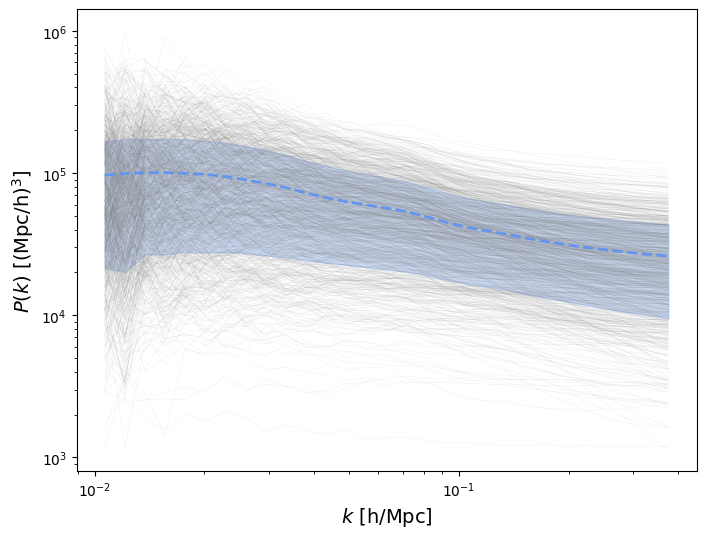

In [12]:

plt.figure(figsize=(8,6))

n_plot = np.min([1000, y_pk_np5.shape[0]])
first = True
for i in range(n_plot):
    if first:
        label = 'muchisimocks test data'
        first = False
    else:
        label = None
    plt.plot(k_pk_np5, y_pk_np5[i], color='grey', alpha=0.2, lw=0.2, label=label)

## Anmult p5

mean = np.mean(y_pk_np5, axis=0)
p16 = np.percentile(y_pk_np5, 16, axis=0)
p84 = np.percentile(y_pk_np5, 84, axis=0)
plt.plot(k_pk_np5, mean, color='cornflowerblue', lw=2, ls='--', label='mean, muchisimocks test data (Anmult5)')
plt.fill_between(k_pk_np5, p16, p84, color='cornflowerblue', alpha=0.3, label=r'16-84% range')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ [h/Mpc]', fontsize=14)
plt.ylabel(r'$P(k)$ [(Mpc/h)$^3$]', fontsize=14)
#plt.legend(fontsize=8)

(-50000000.0, 100000000.0)

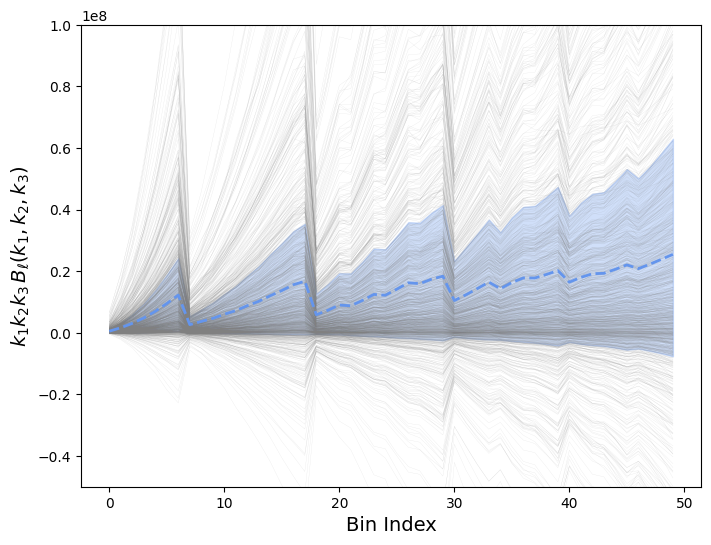

In [18]:
plt.figure(figsize=(8,6))

n_plot = 1000
first = True
for i in range(n_plot):
    if first:
        label = 'muchisimocks test data'
        first = False
    else:
        label = None
    plt.plot(range(len(y_bispec_np5[i])), y_bispec_np5[i], color='grey', alpha=0.2, lw=0.2, label=label)

## Anmult p5
mean = np.mean(y_bispec_np5, axis=0)
p16 = np.percentile(y_bispec_np5, 16, axis=0)
p84 = np.percentile(y_bispec_np5, 84, axis=0)
plt.plot(range(len(mean)), mean, color='cornflowerblue', ls='--', lw=2, label='mean, muchisimocks test data (Anmult5)')
plt.fill_between(range(len(mean)), p16, p84, color='cornflowerblue', alpha=0.3, label=r'16-84% range')
plt.plot()


plt.xlabel(r'Bin Index', fontsize=14)
plt.ylabel(r'$k_1k_2k_3\,B_\ell(k_1,k_2,k_3)$', fontsize=14)
#plt.legend(fontsize=10)
#plt.ylim(p16.min()*2, p84.max()*0.8)
plt.ylim(-0.5e8, 1e8)

In [8]:
data_mode = 'muchisimocks'
statistics = ['pk', 'bispec']
#statistics = ['pk']

### train
tag_params = '_p5_n10000'
tag_biasparams = '_biaszen_p4_n10000'
tag_noise = None
tag_Anoise = None
### test
# tag_params = '_test_p5_n1000'
# tag_biasparams = '_biaszen_p4_n1000'
# tag_noise = '_noise_unit_test_p5_n1000'
# tag_Anoise = '_Anmult_p5_n1000'
## cosmic variance (quijote)
# tag_params="_quijote_p0_n1000"
# tag_biasparams="_b1000_p0_n1"
# tag_noise="_noise_quijote_p0_n1000"
# tag_Anoise="_An1_p0_n1"
tag_datagen = ''
kwargs_data = {
    'tag_datagen': tag_datagen
}

tag_stats = f'_{"_".join(statistics)}'    
tag_data = '_'+data_mode + tag_stats + tag_params + tag_biasparams + tag_datagen
k_arr_np5, y_arr_np5, y_err_np5, idxs_params_np5, params_df_np5, param_dict_fixed_np5, biasparams_df_np5, biasparams_dict_fixed_np5, Anoise_df_np5, Anoise_dict_fixed_np5, random_ints_np5, random_ints_bias_np5 = \
            data_loader.load_data(data_mode, statistics, 
                                    tag_params, tag_biasparams,
                                    #tag_noise=tag_noise, tag_Anoise=tag_Anoise,
                                    tag_data=tag_data,
                                    kwargs=kwargs_data)
            
print(y_arr_np5[0].shape)
#print(y_arr[1].shape)

dir_statistics: /scratch/kstoreyf/muchisimocks/data/pks_mlib/pks_p5_n10000_biaszen_p4_n10000
Loading muchisimocks data from /scratch/kstoreyf/muchisimocks/data/pnns_mlib/pnns_p5_n10000
Found 9605 diff cosmo pnns in /scratch/kstoreyf/muchisimocks/data/pnns_mlib/pnns_p5_n10000


KeyboardInterrupt: 

In [ ]:
theta_np5, param_names_np5 = data_loader.param_dfs_to_theta(idxs_params_np5, params_df_np5, biasparams_df_np5, Anoise_df=Anoise_df_np5)

In [ ]:
# unpack the stats
k_pk_np5 = k_arr_np5[statistics.index('pk')]
y_pk_np5 = y_arr_np5[statistics.index('pk')]

k_bispec_np5 = k_arr_np5[statistics.index('bispec')]
y_bispec_np5 = y_arr_np5[statistics.index('bispec')]


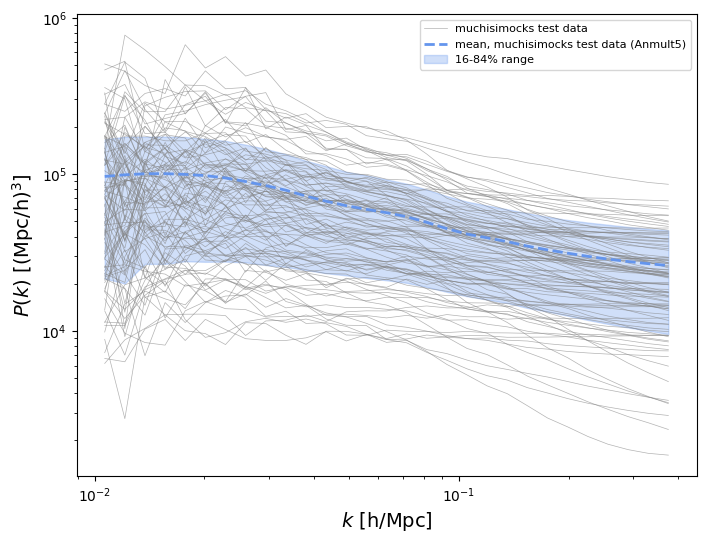

In [ ]:

plt.figure(figsize=(8,6))

n_plot = np.min([100, y_pk_np5.shape[0]])
first = True
for i in range(n_plot):
    if first:
        label = 'muchisimocks test data'
        first = False
    else:
        label = None
    plt.plot(k_pk_np5, y_pk_np5[i], color='grey', alpha=0.6, lw=0.5, label=label)

## Anmult p5

mean = np.mean(y_pk_np5, axis=0)
p16 = np.percentile(y_pk_np5, 16, axis=0)
p84 = np.percentile(y_pk_np5, 84, axis=0)
plt.plot(k_pk_np5, mean, color='cornflowerblue', lw=2, ls='--', label='mean, muchisimocks test data (Anmult5)')
plt.fill_between(k_pk_np5, p16, p84, color='cornflowerblue', alpha=0.3, label=r'16-84% range')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ [h/Mpc]', fontsize=14)
plt.ylabel(r'$P(k)$ [(Mpc/h)$^3$]', fontsize=14)
plt.legend(fontsize=8)